# Proposed Model

### Imports

In [2]:
import torch
print(torch.cuda.is_available())  # True if GPU is available, False otherwise
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the first GPU
print(torch.cuda.current_device)
# print("hello world")

True
1
NVIDIA GeForce GTX 1660 Ti
<function current_device at 0x000001BA203A0FE0>


In [3]:

import torch
import csv
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import InterpolationMode
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,  Subset, random_split,  SubsetRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision import datasets, models
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import os
import seaborn as sns
import random
import torchvision.transforms.functional as F
from PIL import Image
from Datapreprocess import DualTransformDataset_2,Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet, DualTransformDataset
from sklearn.utils import shuffle
from torchinfo import summary
from torchvision.models import inception_v3
from torch.optim import AdamW  # Import AdamW
save_dir = "./DATASETS/ECD AUGMENTED_2 FULL"



### Data Preprocess and Splitting

Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 3701
Inappropriate class size: 3759


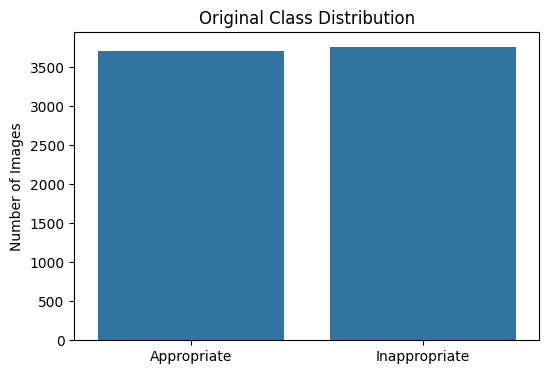

After Augmentation Train set size: 15666
Validation set size: 1119
Test set size: 1119
Balanced class distribution: 3701 appropriate, 3759 inappropriate


In [17]:

# Dataset path
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"

# dataset_path = "./DATASETS/cropped_images_800"
# dataset_path = "./train_45"

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Directory not found: {dataset_path}")

transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for display
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform_inception = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path)
dataset_resnet = ImageFolder(dataset_path)
dataset_inception = ImageFolder(dataset_path)
dataset_visual = ImageFolder(dataset_path, transform=transform_visual)  # For showing images

# Extract class names
class_names = dataset_resnet.classes
print(f"Class Names: {class_names}")
# Separate images by class
appropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 0]
inappropriate_indices = [i for i, (_, label) in enumerate(dataset_resnet.imgs) if label == 1]

# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()



# # ALL INDICES
balanced_indices = list(range(len(dataset)))
balanced_indices = shuffle(balanced_indices)

# Define split sizes (e.g., 70% train, 15% val, 15% test)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure total length matches

# train_idx, val_idx, test_idx = random_split(dataset_inception, [train_size, val_size, test_size])

# Split indices
train_idx = balanced_indices[:train_size]
val_idx = balanced_indices[train_size:train_size + val_size]
test_idx = balanced_indices[train_size + val_size:]

# # Create subsets for ResNet
# train_resnet = Subset(dataset, train_idx)
# val_resnet = Subset(dataset, val_idx)
# test_resnet = Subset(dataset, test_idx)


# # Create subsets for Inception (using the same indices)
# train_inception = Subset(dataset, train_idx)
# val_inception = Subset(dataset, val_idx)
# test_inception = Subset(dataset, test_idx)

# print(f"Before Augmentation Train set size: {len(train_resnet)}")
# print(f"Before Augmentation Train set size: {len(train_inception)}")

# # Save train set with augmentations
# save_images(train_resnet, dataset, "train", augment=True)

# # Save validation set without augmentation
# save_images(val_resnet, dataset, "val", augment=False)

# # Save test set without augmentation
# save_images(test_resnet, dataset, "test", augment=False)

# print(f"✅ All datasets saved in {save_dir}")

# train_resnet_aug = AugmentedImageFolder_resnet(train_resnet)
# train_inception_aug = AugmentedImageFolder_inception(train_inception)

# train_resnet_aug = Applytransform_resnet(train_resnet)
# train_inception_aug = Applytransform_inception(train_inception)


# # Apply transformations to val & test sets
# val_resnet_aug = Applytransform_resnet(val_resnet)
# test_resnet_aug = Applytransform_resnet(test_resnet)

# val_inception_aug = Applytransform_inception(val_inception)
# test_inception_aug = Applytransform_inception(test_inception)

# train_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
# val_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
# test_resnet_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)

# train_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_inception)
# val_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_inception)
# test_inception_aug = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_inception)


# train_loader_resnet = DataLoader(train_resnet_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# val_loader_resnet = DataLoader(val_resnet_aug, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
# test_loader_resnet = DataLoader(test_resnet_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)

# train_loader_inception = DataLoader(train_inception_aug, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
# val_loader_inception = DataLoader(val_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)
# test_loader_inception = DataLoader(test_inception_aug, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)


# train_subset = Subset(dataset, train_idx)
# val_subset = Subset(dataset, val_idx)
# test_subset = Subset(dataset, test_idx)

# train_dataset = DualTransformDataset(train_subset)
# val_dataset = DualTransformDataset(val_subset)
# test_dataset = DualTransformDataset(test_subset)

train_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "train"))

val_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "val"))

test_dataset = DualTransformDataset_2(root=os.path.join(save_dir, "test"))
   

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)






print(f"After Augmentation Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# print(f"After Augmentation Train set size: {len(train_inception_aug)}")
# print(f"Validation set size: {len(val_inception_aug)}")
# print(f"Test set size: {len(test_inception_aug)}")


# Check class distribution in the balanced dataset
print(f"Balanced class distribution: {len(appropriate_indices)} appropriate, {len(inappropriate_indices)} inappropriate")



## sample images

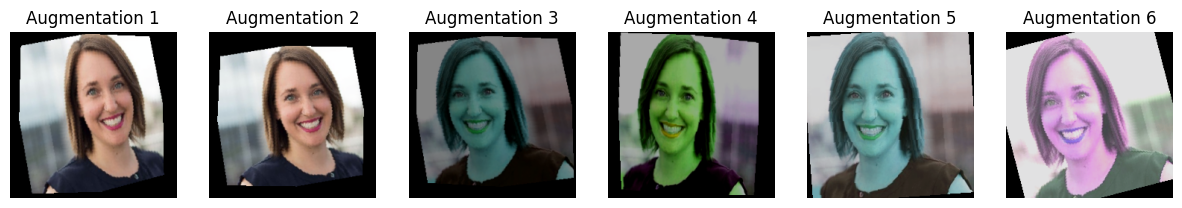

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to visualize multiple augmentations on the same image
def visualize_all_augmentations(dataset, index=0, num_augmentations=6):
    fig, axes = plt.subplots(1, num_augmentations, figsize=(15, 5))

    for i in range(num_augmentations):
        image, label = dataset[index * 2 + (i % 2)]  # Get image (flipped or not)

        # Convert tensor to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()
        
        # Reverse normalization for better visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean  # Undo normalization
        image_np = np.clip(image_np, 0, 1)  # Clip values to [0,1]

        axes[i].imshow(image_np)
        axes[i].axis("off")
        axes[i].set_title(f"Augmentation {i + 1}")

    plt.show()

# Test function
visualize_all_augmentations(AugmentedImageFolder_resnet(dataset))


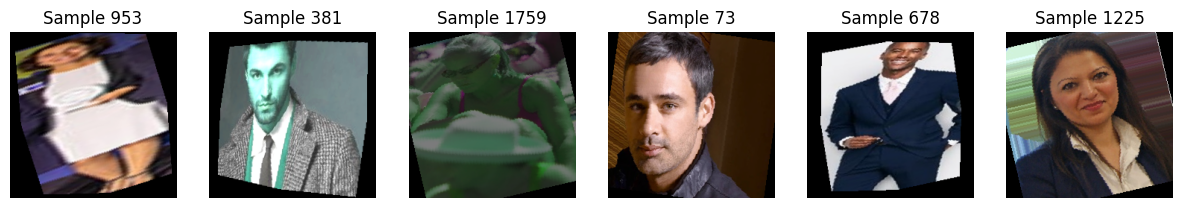

In [8]:
import random

# Function to visualize multiple random augmented images
def visualize_random_augmentations(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Pick random indices to ensure variety
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Get a randomly chosen augmented image

        # Convert tensor to numpy
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Reverse normalization for better visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean  # Undo normalization
        image_np = np.clip(image_np, 0, 1)  # Clip values to valid range

        axes[i].imshow(image_np)
        axes[i].axis("off")
        axes[i].set_title(f"Sample {idx}")

    plt.show()

# Test function
visualize_random_augmentations(AugmentedImageFolder_resnet(dataset))


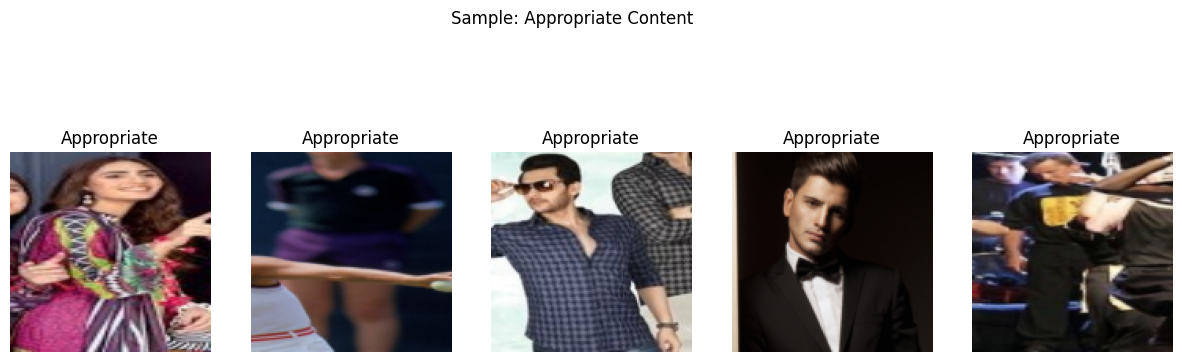

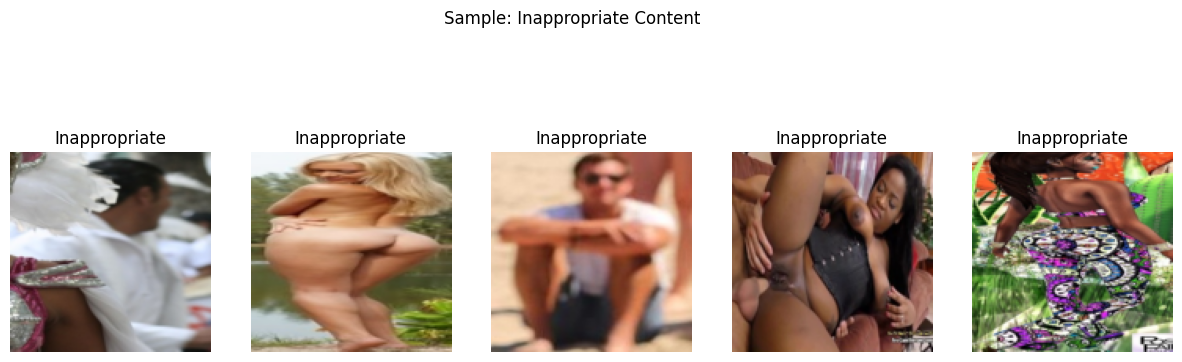

In [9]:
# Sample and show images from both classes
def show_images(indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(random.sample(indices, num_images)):
        img, label = dataset_visual[idx]
        axes[i].imshow(img.permute(1, 2, 0))  # Convert to (H, W, C)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

show_images(appropriate_indices, "Sample: Appropriate Content")
show_images(inappropriate_indices, "Sample: Inappropriate Content")




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to

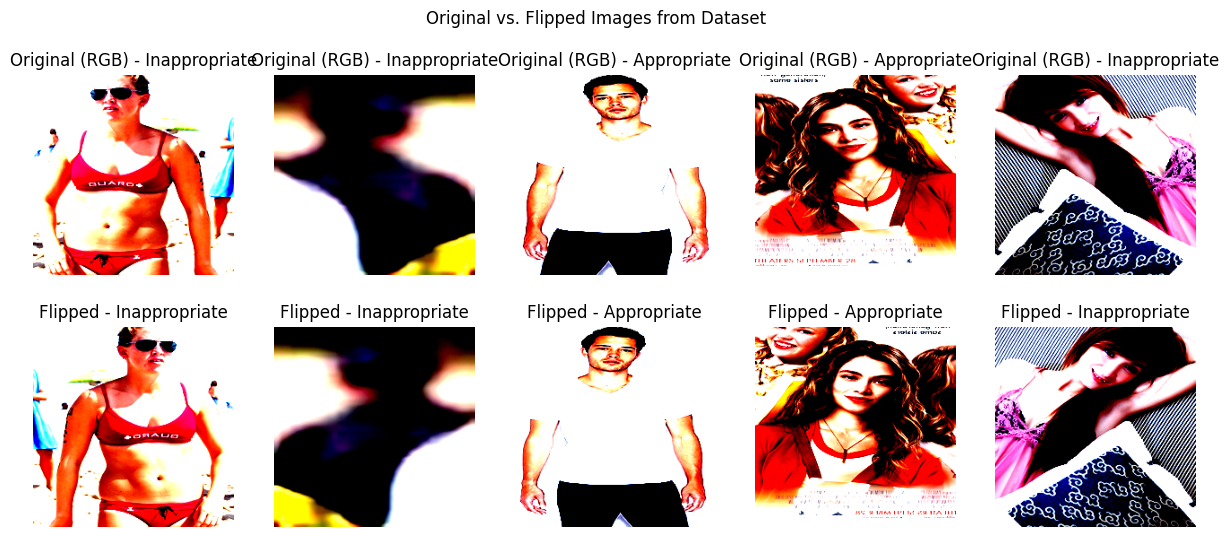

In [114]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display original vs. augmented (flipped) images
def show_original_vs_augmented(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 2 - 1)  # Select original images only
        original_idx = index * 2  # Original image index
        flipped_idx = original_idx + 1  # Flipped image index

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)
        mode_original = img_pil.mode  # Check mode

        # ✅ Check if image is in RGB mode
        if mode_original != "RGB":
            print(f"Warning: Image {img_path} is in {mode_original} mode. Converting to RGB.")
            img_pil = img_pil.convert("RGB")

        # Load images from train_dataset (already transformed)
        img_original, label_original = train_dataset[original_idx]
        img_flipped, label_flipped = train_dataset[flipped_idx]

        # Move tensors to CPU before converting to numpy
        img_original_np = img_original.cpu().permute(1, 2, 0).numpy()
        img_flipped_np = img_flipped.cpu().permute(1, 2, 0).numpy()

        # Display original
        axes[0, i].imshow(img_original_np)
        axes[0, i].set_title(f"Original ({mode_original}) - {raw_dataset.classes[label_original]}")
        axes[0, i].axis("off")

        # Display flipped
        axes[1, i].imshow(img_flipped_np)
        axes[1, i].set_title(f"Flipped - {raw_dataset.classes[label_flipped]}")
        axes[1, i].axis("off")

    plt.suptitle("Original vs. Flipped Images from Dataset")
    plt.show()

# Call function using the correct variables
show_original_vs_augmented(train_resnet, dataset)


## Model Initialization

In [24]:

# # Define the model
# class FusionModel(nn.Module):
#     def __init__(self, num_classes):
#         super(FusionModel, self).__init__()
        
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#         pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
#         self.inception = models.inception_v3(aux_logits=False)
#         state_dict = pretrained_model.state_dict()
#         self.inception.load_state_dict(state_dict, strict=False)
        
#         # Step 1: Freeze All Layers Initially**
#         for param in self.resnet.parameters():
#             param.requires_grad = False
#         for param in self.inception.parameters():
#             param.requires_grad = False
        
#         # for param in self.resnet.fc.parameters():
#         #       param.requires_grad = True
#         # for param in self.inception.fc.parameters():
#         #       param.requires_grad = True    
              
#         self.resnet.fc = nn.Identity()
#         self.inception.fc = nn.Identity()
                   
#         # self.resnet.fc = None
#         # self.inception.fc = None
        
#         self.batch_norm = nn.BatchNorm1d(4096)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(4096, num_classes)
        
#     def forward(self, x_resnet, x_inception):
#         resnet_features = self.resnet(x_resnet)
#         print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output
#         inception_features = self.inception(x_inception)
#         print(f"ResNet Features Shape: {inception_features.shape}")  # Debugging Output

#         if isinstance(inception_features, tuple):  # InceptionV3 returns a tuple
#             inception_features = inception_features[0]  # Take only the main output
#         fused_features = torch.cat((resnet_features, inception_features), dim=1)
#         fused_features = self.batch_norm(fused_features)
#         fused_features = self.relu(fused_features)
#         fused_features = self.dropout(fused_features)
#         output = torch.sigmoid(self.fc(fused_features))
#         output = self.fc(fused_features)  # No sigmoid here

#         return output

class FusionModel(nn.Module):
    def __init__(self, num_classes):
        super(FusionModel, self).__init__()

        # Load pretrained ResNet50 and freeze all layers
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Identity()  # Remove ResNet FC layer

        # Load pretrained InceptionV3
        # self.inception = models.inception_v3(aux_logits=False)
        # pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        # state_dict = pretrained_model.state_dict()
        # self.inception.load_state_dict(state_dict, strict=False)

        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        inception_model = models.inception_v3(aux_logits=False)
        inception_model.load_state_dict(pretrained_model.state_dict(), strict=False)


        # Freeze all Inception layers
        
        inception_model.fc = nn.Identity()
        self.inception_preprocess = nn.Sequential(
            inception_model.Conv2d_1a_3x3,
            inception_model.Conv2d_2a_3x3,
            inception_model.Conv2d_2b_3x3,
            inception_model.maxpool1,
            inception_model.Conv2d_3b_1x1,
            inception_model.Conv2d_4a_3x3,
            inception_model.maxpool2,
            inception_model.Mixed_5b,
            inception_model.Mixed_5c,
            inception_model.Mixed_5d,
            inception_model.Mixed_6a,
            inception_model.Mixed_6b,
            inception_model.Mixed_6c,
            inception_model.Mixed_6d,
            inception_model.Mixed_6e,
        )

        # ✅ **Only keep high-level Inception layers**
        self.inception_top_layers = nn.Sequential(
            inception_model.Mixed_7a,
            inception_model.Mixed_7b,
            inception_model.Mixed_7c,
            nn.AdaptiveAvgPool2d((1, 1)),  # Global avg pooling
            # nn.Flatten()  # Flatten to 1D
        )
        
        for param in inception_model.parameters():
            param.requires_grad = False
            

        # Free memory
        # del pretrained_model

        # Feature sizes
        resnet_out_features = 2048  # ResNet50 last layer output
        inception_out_features = 2048  # InceptionV3 last layer output

        # Fully connected fusion head
        self.batch_norm = nn.BatchNorm1d(resnet_out_features + inception_out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(resnet_out_features + inception_out_features, num_classes)

    def forward(self, x_resnet, x_inception):
        # Extract ResNet50 features
        resnet_features = self.resnet(x_resnet)
        # print(f"ResNet Features Shape: {resnet_features.shape}")  # Debugging Output


        # ✅ **Process input through necessary Inception layers to get correct shape**
        x_inception = self.inception_preprocess(x_inception)
        # print(f"Inception Features Shape: {x_inception.shape}")  # Debugging Output

        inception_features = self.inception_top_layers(x_inception).squeeze(-1).squeeze(-1)        
        # print(f"Inception Features Shape: {inception_features.shape}")  # Debugging Output

        # Concatenate features
        
        fused_features = torch.cat((resnet_features, inception_features), dim=1)
        fused_features = self.batch_norm(fused_features)
        fused_features = self.relu(fused_features)
        fused_features = self.dropout(fused_features)
        output = torch.sigmoid(self.fc(fused_features))

        return output
    
    
model = FusionModel(num_classes=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)




e:\THESIS PROJECT FOLDER\.venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [25]:
import torch

# Example Input (Batch Size = 2, Channels = 3, Image Size = 224x224)
x_resnet = torch.randn(2, 3, 224, 224)  # Input for ResNet50
x_inception = torch.randn(2, 3, 299, 299)  # Input for InceptionV3

model = FusionModel(num_classes=1)  # Assuming binary classification
output = model(x_resnet, x_inception)


### model summary

In [16]:


torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
# print(model)
summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])

# for name, param in model.named_parameters():
#     print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

Layer (type:depth-idx)                             Output Shape              Param #
FusionModel                                        --                        --
├─ResNet50Model: 1-1                               --                        --
│    └─ResNet: 2-1                                 --                        --
│    │    └─Conv2d: 3-1                            --                        (9,408)
│    │    └─BatchNorm2d: 3-2                       --                        (128)
│    │    └─ReLU: 3-3                              --                        --
│    │    └─MaxPool2d: 3-4                         --                        --
│    │    └─Sequential: 3-5                        --                        (215,808)
│    │    └─Sequential: 3-6                        --                        (1,219,584)
│    │    └─Sequential: 3-7                        --                        (7,098,368)
│    │    └─Sequential: 3-8                        --                        (14,9

## Plots

In [23]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

In [12]:
# Training loop
def train_model(model, train_loader_resnet, train_loader_inception, val_loader_resnet, val_loader_inception, 
                criterion, optimizer, epochs=5,scheduler=None):
   
    
    # for epoch in range(epochs):
    #     if epoch == 2:  # Unfreeze last block of ResNet and Inception
    #         for param in model.resnet.layer4.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7c.parameters():  # Last inception block
    #             param.requires_grad = True
        
    #     if epoch == 4:  # Unfreeze more layers gradually
    #         for param in model.resnet.layer3.parameters():
    #             param.requires_grad = True
    #         for param in model.inception.Mixed_7b.parameters():
    #             param.requires_grad = True
                
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
    "epoch": [],
    "class_names": [],
    "confusion_matrix": [],
    "accuracy": [],
    "fpr": [],
    "fnr": [],
    "auc_roc": [],
    "roc_curve_fpr": [],
    "roc_curve_tpr": []
}

       
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm on the zip object directly
        progress_bar = tqdm(zip(train_loader_resnet, train_loader_inception), 
                             total=len(train_loader_resnet), 
                             desc=f"Epoch {epoch+1}/{epochs}")

        for (resnet_batch, inception_batch) in progress_bar:
            x_resnet, y = resnet_batch
            x_inception, _ = inception_batch
            
            # Move data to the appropriate device
            x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet, x_inception).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)          
            correct += (preds == y).sum().item()
            total += y.size(0)

            # Update progress bar with loss and accuracy
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)
            

        epoch_loss = running_loss / len(train_loader_resnet)
        epoch_acc = 100 * correct / total
       
        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for (resnet_batch, inception_batch) in zip(val_loader_resnet, val_loader_inception):
                x_resnet, y = resnet_batch
                x_inception, _ = inception_batch
                x_resnet, x_inception, y = x_resnet.to(device), x_inception.to(device), y.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()  # ✅ Logits threshold at 0 (not 0.5 since no sigmoid in forward)                
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                
                
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())


        val_loss /= len(val_loader_resnet)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0
        
        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")
        
        # Store metrics
       
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
     

        model.train()  # Return model to training mode
        if scheduler:
                # scheduler.step(val_loss)
                print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
                scheduler.step()
                print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

            # scheduler.step()  

    print("Training complete")
   
    # Compute Additional Metrics
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    print("\nAdditional Metrics:") 
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")  # Explicit print
    # Save Additional Metrics
  # Update metrics dictionary for the current epoch (replace `epoch_number` with actual epoch)
    metrics["class_names"].append(class_names)
    metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    metrics["fpr"].append(fpr)
    metrics["fnr"].append(fnr)
    metrics["auc_roc"].append(auc_score)
    metrics["roc_curve_fpr"].append(fpr_vals)
    metrics["roc_curve_tpr"].append(tpr_vals)
   
    return history, metrics  # Return history dictionary for immediate plotting if needed


### Fine Tune layers

In [27]:
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR

for param in model.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
    param.requires_grad = True
# for param in model.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# Unfreezing the last few Inception blocks
for param in model.inception_top_layers[0].parameters():  # Unfreeze Mixed_7a
    param.requires_grad = True
for param in model.inception_top_layers[1].parameters():  # Unfreeze Mixed_7a
    param.requires_grad = True
# for param in model.inception_top_layers[2].parameters():  # Unfreeze Mixed_7a
#     param.requires_grad = True

# for param in model.inception_top_layers[3].parameters():  # Unfreeze Mixed_7b
#     param.requires_grad = True

# for param in model.inception_top_layers[4].parameters():  # Unfreeze Mixed_7c
#     param.requires_grad = True


# for param in model.inception_top_layers.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception_top_layers.Mixed_7a.parameters():
#     param.requires_grad = True
    
# for param in model.inception.Mixed_7c.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_7a.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6e.parameters():
#     param.requires_grad = True

# for param in model.inception.Mixed_6d.parameters():
#     param.requires_grad = True


# for layer in [model.inception.Mixed_6d, model.inception.Mixed_6e,
#               model.inception.Mixed_7a, model.inception.Mixed_7b,
#               model.inception.Mixed_7c]:
#     for param in layer.parameters():
#         param.requires_grad = True

# for param in model.inception_preprocess.parameters():
#     param.requires_grad = True


# print(model)
# summary(model, input_size=[(1, 3, 224, 224), (1, 3, 299, 299)])
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


resnet.conv1.weight: Frozen
resnet.bn1.weight: Frozen
resnet.bn1.bias: Frozen
resnet.layer1.0.conv1.weight: Frozen
resnet.layer1.0.bn1.weight: Frozen
resnet.layer1.0.bn1.bias: Frozen
resnet.layer1.0.conv2.weight: Frozen
resnet.layer1.0.bn2.weight: Frozen
resnet.layer1.0.bn2.bias: Frozen
resnet.layer1.0.conv3.weight: Frozen
resnet.layer1.0.bn3.weight: Frozen
resnet.layer1.0.bn3.bias: Frozen
resnet.layer1.0.downsample.0.weight: Frozen
resnet.layer1.0.downsample.1.weight: Frozen
resnet.layer1.0.downsample.1.bias: Frozen
resnet.layer1.1.conv1.weight: Frozen
resnet.layer1.1.bn1.weight: Frozen
resnet.layer1.1.bn1.bias: Frozen
resnet.layer1.1.conv2.weight: Frozen
resnet.layer1.1.bn2.weight: Frozen
resnet.layer1.1.bn2.bias: Frozen
resnet.layer1.1.conv3.weight: Frozen
resnet.layer1.1.bn3.weight: Frozen
resnet.layer1.1.bn3.bias: Frozen
resnet.layer1.2.conv1.weight: Frozen
resnet.layer1.2.bn1.weight: Frozen
resnet.layer1.2.bn1.bias: Frozen
resnet.layer1.2.conv2.weight: Frozen
resnet.layer1.2.bn2.

### Train Model

In [ ]:
# "STEADY LEARNING RATE"

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
import torch.optim.adamax


criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.0001)
# optimizer = optim.Adamax(model.fc.parameters(), lr=0.0001, weight_decay=0.0001)
train_loader_resnet = DataLoader(train_resnet_aug, batch_size=32, shuffle=True, num_workers=4)
train_loader_inception = DataLoader(train_inception_aug, batch_size=32, shuffle=True, num_workers=4)

Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=10)

Epoch 1/10: 100%|██████████| 73/73 [00:30<00:00,  2.40it/s, accuracy=80.4, loss=0.241]



Epoch 1/10: Train Loss = 0.4055, Train Accuracy = 80.45%
Validation Loss = 0.2332, Validation Accuracy = 90.40%



In [ ]:
# "DECAYING LEARNING RATE"
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00025, weight_decay=0.0001)

            # Set DataLoaders
train_loader_resnet = DataLoader(train_resnet, batch_size=64, shuffle=True)
train_loader_inception = DataLoader(train_inception, batch_size=64, shuffle=True)



            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
Fsecondhistory, Fsecondmetrics = train_model(model, train_loader_resnet, train_loader_inception, 
                                                       val_loader_resnet, val_loader_inception, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

### Model Evaluation using Test Set

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
model = torch.jit.load("Training Merge/models/fixedresnet_inception_fullmodel_cropped15epochs_non-aug_nodense.pt")
model.to(device)
model.eval()
def model_eval():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }


    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for batch in test_loader:
                x_resnet, x_inception, labels = batch
                x_resnet, x_inception, labels = x_resnet.to(device), x_inception.to(device), labels.to(device).float()

                outputs = model(x_resnet, x_inception).squeeze()
                preds = (outputs > 0.5).cpu().int().numpy()

                # Store ground-truth labels and predictions
                y_true.extend(labels.cpu().int().numpy())
                y_pred.extend(preds)
                y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC
                




    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    test_metrics["class_names"].append(class_names)
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)
    

    report = classification_report(y_true, y_pred)
    accuracyscore = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracyscore}")
    
    return test_metrics, report, accuracyscore


test_metrics, report, accuracyscore = model_eval()



Test Set Metrics:
False Positive Rate (FPR): 0.1243
False Negative Rate (FNR): 0.0745
AUC-ROC Score: 0.9702
Confusion Matrix:
[[486  69]
 [ 42 522]]
**Fine-Tuned Model Evaluation**
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       555
           1       0.88      0.93      0.90       564

    accuracy                           0.90      1119
   macro avg       0.90      0.90      0.90      1119
weighted avg       0.90      0.90      0.90      1119

Accuracy Score: 0.900804289544236


### Training Results

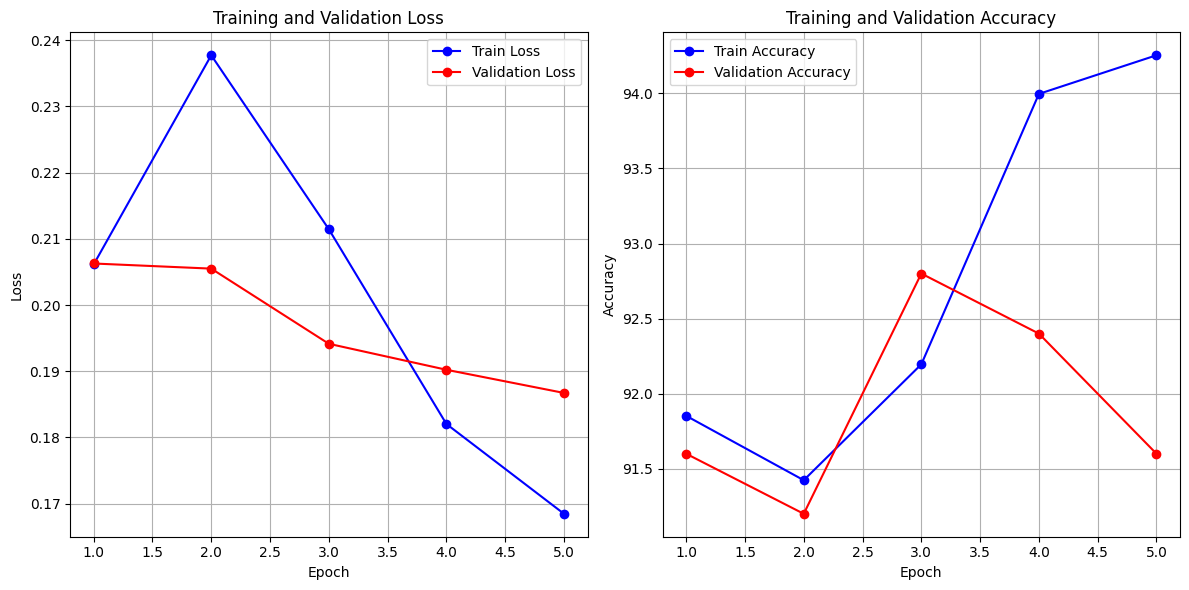

In [23]:
plot_from_history(Fsecondhistory)

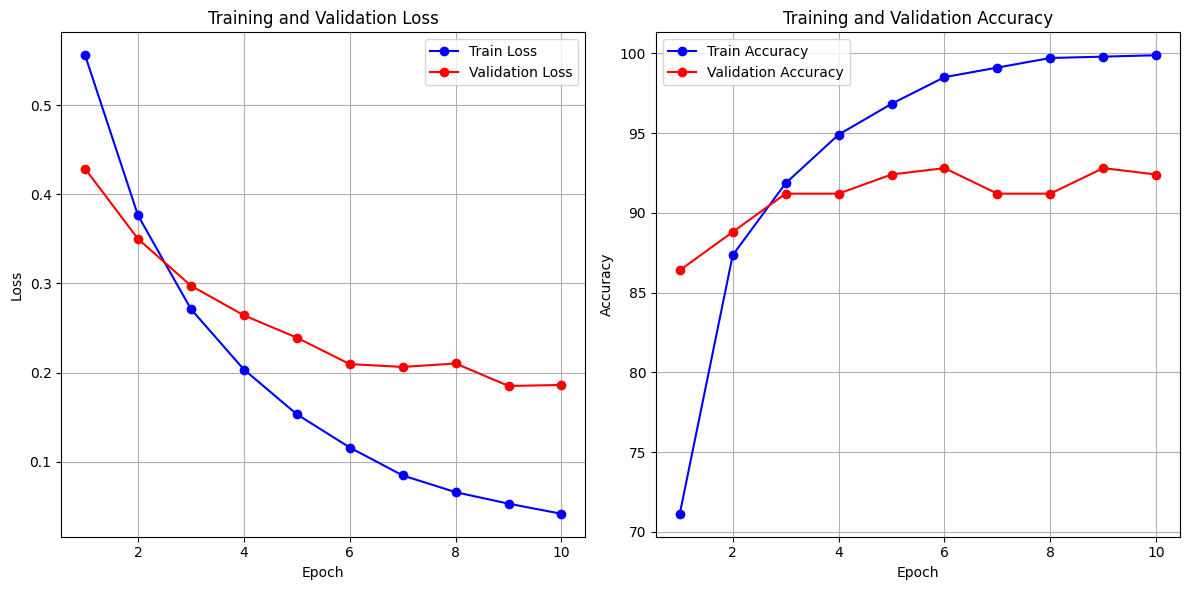

In [107]:
plot_from_history(Fsecondhistory)

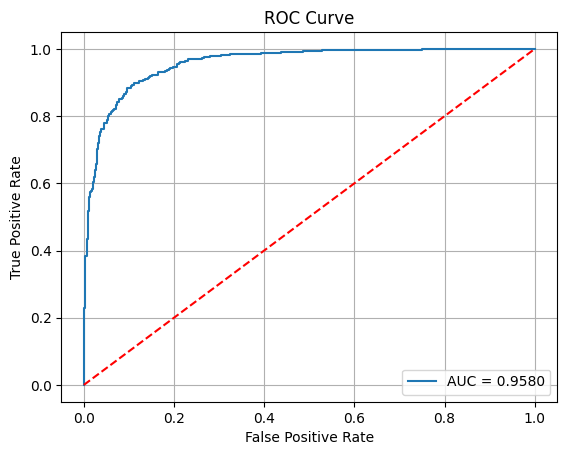

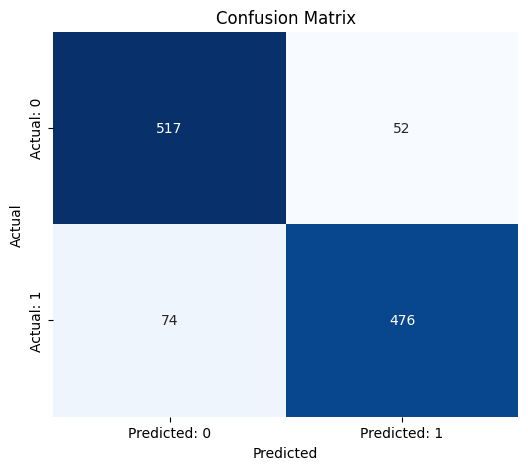

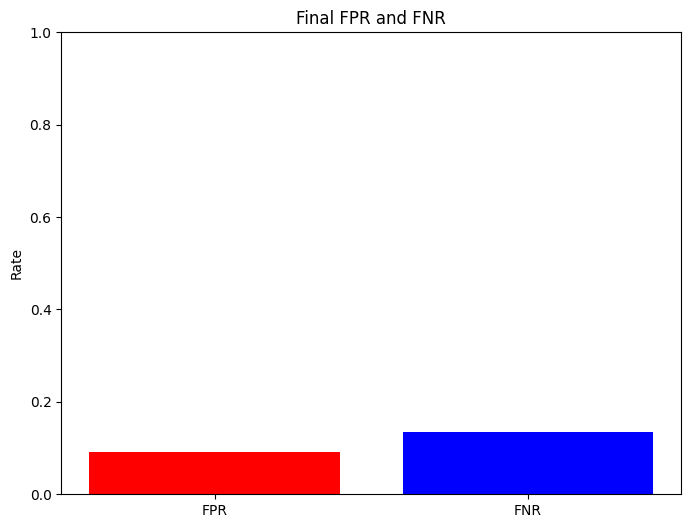

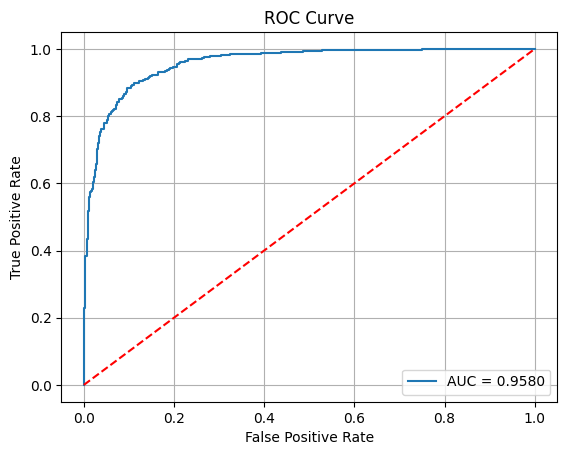

In [ ]:
# Fsecondmetrics_flat = {
#     "class_names": Fsecondmetrics["class_names"],
#     "fpr": Fsecondmetrics["fpr"],
#     "fnr": Fsecondmetrics["fnr"],
#     "auc_roc": Fsecondmetrics["auc_roc"],
#     "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in Fsecondmetrics["roc_curve_fpr"]],
#     "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in Fsecondmetrics["roc_curve_tpr"]],
#     "confusion_matrix": [', '.join(map(str, cm)) for cm in Fsecondmetrics["confusion_matrix"]]
# }

Fsecondmetrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

plot_roc_curve(Fsecondmetrics_flat)
plot_metrics(Fsecondmetrics_flat)

### Save training results

In [109]:
Fsecondmetrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}
with open("training_history/fixedproposed_classification_report10epochs_non-aug.txt", "w") as file:
    file.write(report + "\n")  # Write the classification report
    file.write(f"Accuracy Score: {accuracyscore}\n") 

# df = pd.DataFrame(Fsecondhistory)
# df.to_csv('training_history/fixedsecond_training_history5epochs_finetuneF_nodense.csv', index=False)
metrics_df = pd.DataFrame(Fsecondmetrics_flat)
metrics_df.to_csv('training_history/fixedcecond_training_metrics10epochs_non-aug.csv', index=False)



#### Read Saved Results

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       555
           1       0.88      0.93      0.90       564

    accuracy                           0.90      1119
   macro avg       0.90      0.90      0.90      1119
weighted avg       0.90      0.90      0.90      1119

Accuracy Score: 0.900804289544236



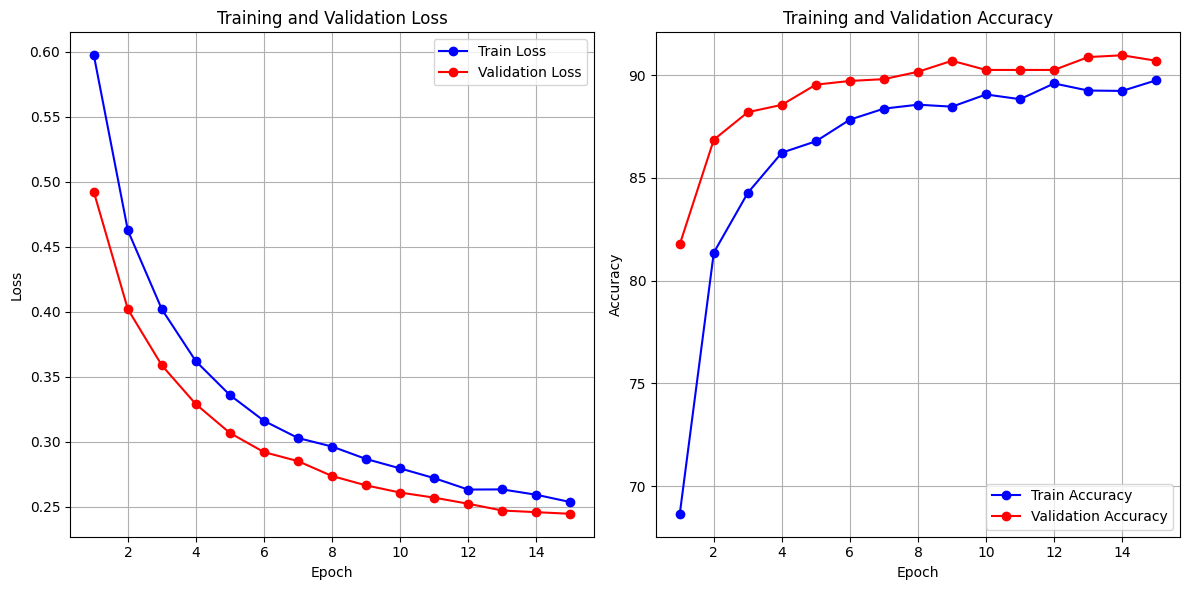

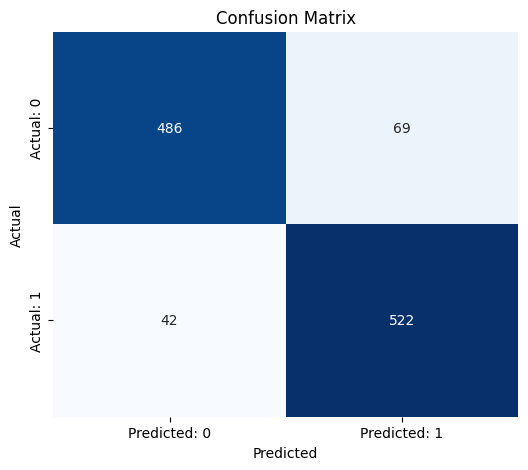

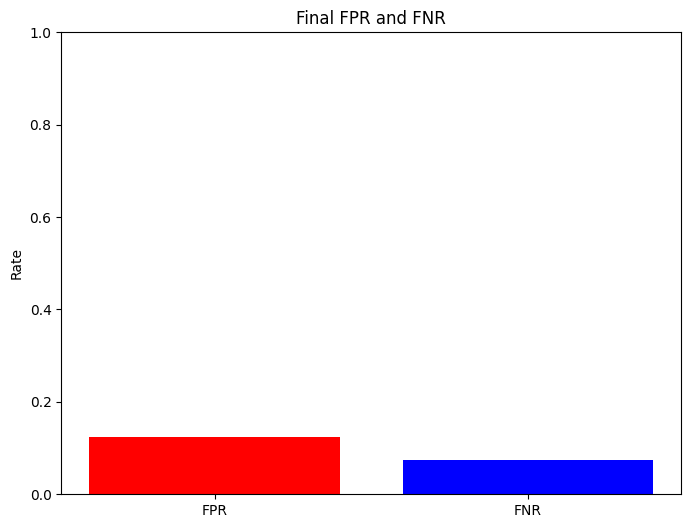

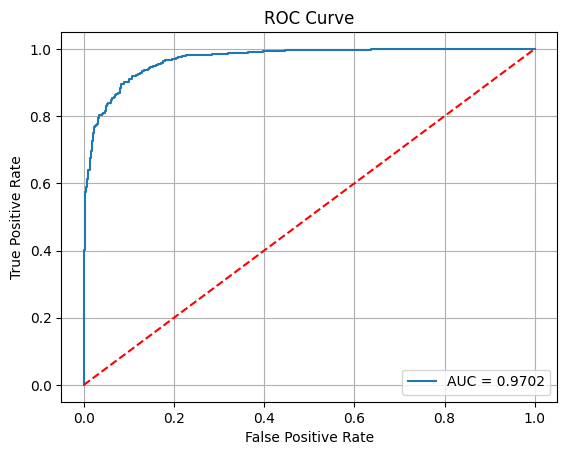

In [35]:
with open("Training Merge/fixedproposed_classification_report15epochs_non-aug_nodense.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('Training Merge/fixedsecond_training_history15epochs_non-aug_nodense.csv')
Fsecondhistory = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(Fsecondhistory)

metrics_df = pd.read_csv('Training Merge/fixedcecond_training_metrics15epochs_non-aug_nodense.csv')
plot_metrics(metrics_df)

## Save Models

In [81]:
torch.save(model, "../Saved models/resnet_inception_fullmodel_cropped10epochs.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("../Saved models/resnet_inception_fullmodel_cropped10epochs.pt")

#### Use saved model

In [83]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Suppress specific UserWarning for InceptionV3
warnings.filterwarnings("ignore", message="Scripted Inception3 always returns Inception3 Tuple")

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fussionmodel = torch.load('Saved models/resnet_inception_fullmodel_cropped.pth')
# fussionmodel.to(device)
# fussionmodel.eval() 

fuse = torch.jit.load("../Saved models/resnet_inception_fullmodel_cropped10epochs.pt")
fuse.to(device)
fuse.eval()

# # Perform the forward pass during prediction
# with torch.no_grad():  # Disable gradient tracking during inference for efficiency
#     x_resnet = x_resnet.to(device)  # Make sure the input is on the correct device (CPU/GPU)
#     x_inception = x_inception.to(device)
#     output = model(x_resnet, x_inception)
# # Image preprocessing functions equivalent to TensorFlow preprocessing

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Inception normalization
])

def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    img_inception = Image.open(img_path).convert('RGB')

    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    img_tensor_inception = inception_transform(img_inception).unsqueeze(0)
    
    return img_tensor_resnet, img_tensor_inception

def predict_image(img_path):
    img_tensor_resnet, img_tensor_inception = preprocess_image(img_path)
    img_tensor_resnet, img_tensor_inception = img_tensor_resnet.to(device), img_tensor_inception.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = fuse(img_tensor_resnet, img_tensor_inception)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")

['Appropriate', 'Inappropriate']
Predicted Class for ./DARKNET/test.jpg: Appropriate
Predicted Class for ./DARKNET/test1.jpg: Appropriate
Predicted Class for ./DARKNET/test2.jpg: Inappropriate
Predicted Class for ./DARKNET/test3.jpg: Inappropriate
Predicted Class for ./DARKNET/test4.jpg: Inappropriate
Predicted Class for ./DARKNET/test5.jpg: Inappropriate
Predicted Class for ./DARKNET/test6.jpg: Inappropriate
Predicted Class for ./DARKNET/test7.jpg: Appropriate
Predicted Class for ./DARKNET/zeb.jpg: Appropriate


# BASELINE MODEL 

### Imports

In [332]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.transforms import InterpolationMode
from PIL import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torchvision.models import ResNet50_Weights
import os
import numpy as np
from tqdm import tqdm
import glob
import pandas as pd
from torch.utils.data import DataLoader, Dataset,  Subset
from torchvision.datasets import ImageFolder
import seaborn as sns
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from Datapreprocess import Applytransform_inception, Applytransform_resnet, AugmentedImageFolder_inception, AugmentedImageFolder_resnet, DualTransformDataset_2
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import torch.optim as optim
from torchinfo import summary
from torch.optim import AdamW  # Import AdamW
# save_dir = "./DATASETS/MMU DATASET CROPPED AUGMENTED FULL2"
# save_dir = "./DATASETS/MMU DATASET CROPPED NONAUGMENTED FULL2"
save_dir = "./DATASETS/ECD NONAUGMENTED_2 FULL"




### Data Preprocess and Splitting

Directory found: ./DATASETS/ECD DATASET CROPPED FULL
Contents: ['Appropriate', 'Inappropriate']
Class Names: ['Appropriate', 'Inappropriate']
Appropriate class size: 3701
Inappropriate class size: 3759


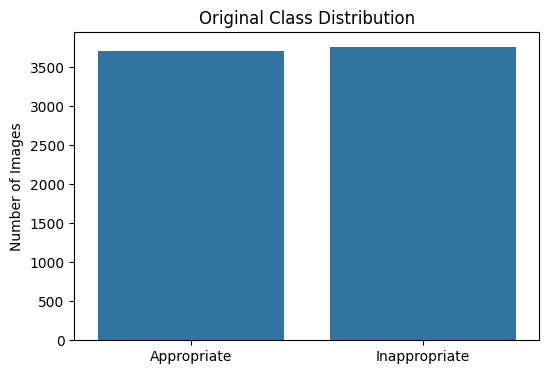

Augmented Training Dataset Size: 5222 (Includes Flipped Images)
Validation Dataset Size: 1119
Test Dataset Size: 1119


In [335]:
# dataset_path = "./train_45"
# dataset_path = "./DATASETS/cropped_images_800"
dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"

# dataset_path = "./DATASETS/ECD DATASET CROPPED FULL"
if not os.path.exists(dataset_path):
    print(f"Directory not found: {dataset_path}")
else:
    print(f"Directory found: {dataset_path}")
    print("Contents:", os.listdir(dataset_path))

# Define transformations
transform_visual = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
val_test_transform_resnet = transforms.Compose([
    transforms.Resize((229, 229), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform_inception = transforms.Compose([
    transforms.Resize((299, 299), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load raw dataset without transformation
dataset_raw = ImageFolder(dataset_path)
class_names = dataset_raw.classes
class_to_idx = dataset_raw.class_to_idx
print("Class Names:", class_names)

# Extract class indices
labels = [label for _, label in dataset_raw.samples]
appropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Appropriate"]]
inappropriate_indices = [i for i, label in enumerate(labels) if label == class_to_idx["Inappropriate"]]


# Check class sizes
print(f"Appropriate class size: {len(appropriate_indices)}")
print(f"Inappropriate class size: {len(inappropriate_indices)}")

# Plot original class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=["Appropriate", "Inappropriate"], y=[len(appropriate_indices), len(inappropriate_indices)])
plt.title("Original Class Distribution")
plt.ylabel("Number of Images")
plt.show()

# # Balance dataset by undersampling the larger class
# min_class_size = min(len(appropriate_indices), len(inappropriate_indices))
# appropriate_indices = random.sample(appropriate_indices, min_class_size)
# inappropriate_indices = random.sample(inappropriate_indices, min_class_size)

# # Merge & shuffle indices
# balanced_indices = appropriate_indices + inappropriate_indices
# random.shuffle(balanced_indices)

balanced_indices = list(range(len(dataset_raw)))
balanced_indices = shuffle(balanced_indices)


# Define split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * len(balanced_indices))
val_size = int(0.15 * len(balanced_indices))
test_size = len(balanced_indices) - train_size - val_size

# Split indices
train_indices = balanced_indices[:train_size]
val_indices = balanced_indices[train_size:train_size + val_size]
test_indices = balanced_indices[train_size + val_size:]

# Create Subset datasets
# dataset_train = Subset(dataset_raw, train_indices)
# dataset_val = Subset(dataset_raw, val_indices)
# dataset_test = Subset(dataset_raw, test_indices)

# Wrap in AugmentedImageFolder for flipping
# dataset_train = Applytransform_resnet(dataset_train)

# dataset_train = AugmentedImageFolder_inception(dataset_train)


# dataset_train = Applytransform_resnet(dataset_train)
# # Apply transformations to val & test sets



# dataset_val = Applytransform_resnet(dataset_val)
# dataset_test = Applytransform_resnet(dataset_test)
# dataset_val = Applytransform_inception(dataset_val)
# dataset_test = Applytransform_inception(dataset_test)
# Create DataLoaders
# print(f"Before Augmentation Train set size: {len(dataset_train)}")

dataset_train = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_resnet)
dataset_val = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_resnet)
dataset_test = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_resnet)

# dataset_train = datasets.ImageFolder(root=os.path.join(save_dir, "train"), transform=val_test_transform_inception)
# dataset_val = datasets.ImageFolder(root=os.path.join(save_dir, "val"), transform=val_test_transform_inception)
# dataset_test = datasets.ImageFolder(root=os.path.join(save_dir, "test"), transform=val_test_transform_inception)


# dataset_train = DualTransformDataset_2(root=os.path.join(save_dir, "train"))

# dataset_val = DualTransformDataset_2(root=os.path.join(save_dir, "val"))

# dataset_test = DualTransformDataset_2(root=os.path.join(save_dir, "test"))
   


# train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=4)
# val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, num_workers=4)
# test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Augmented Training Dataset Size: {len(dataset_train)} (Includes Flipped Images)")
print(f"Validation Dataset Size: {len(dataset_val)}")
print(f"Test Dataset Size: {len(dataset_test)}")


### Sample images

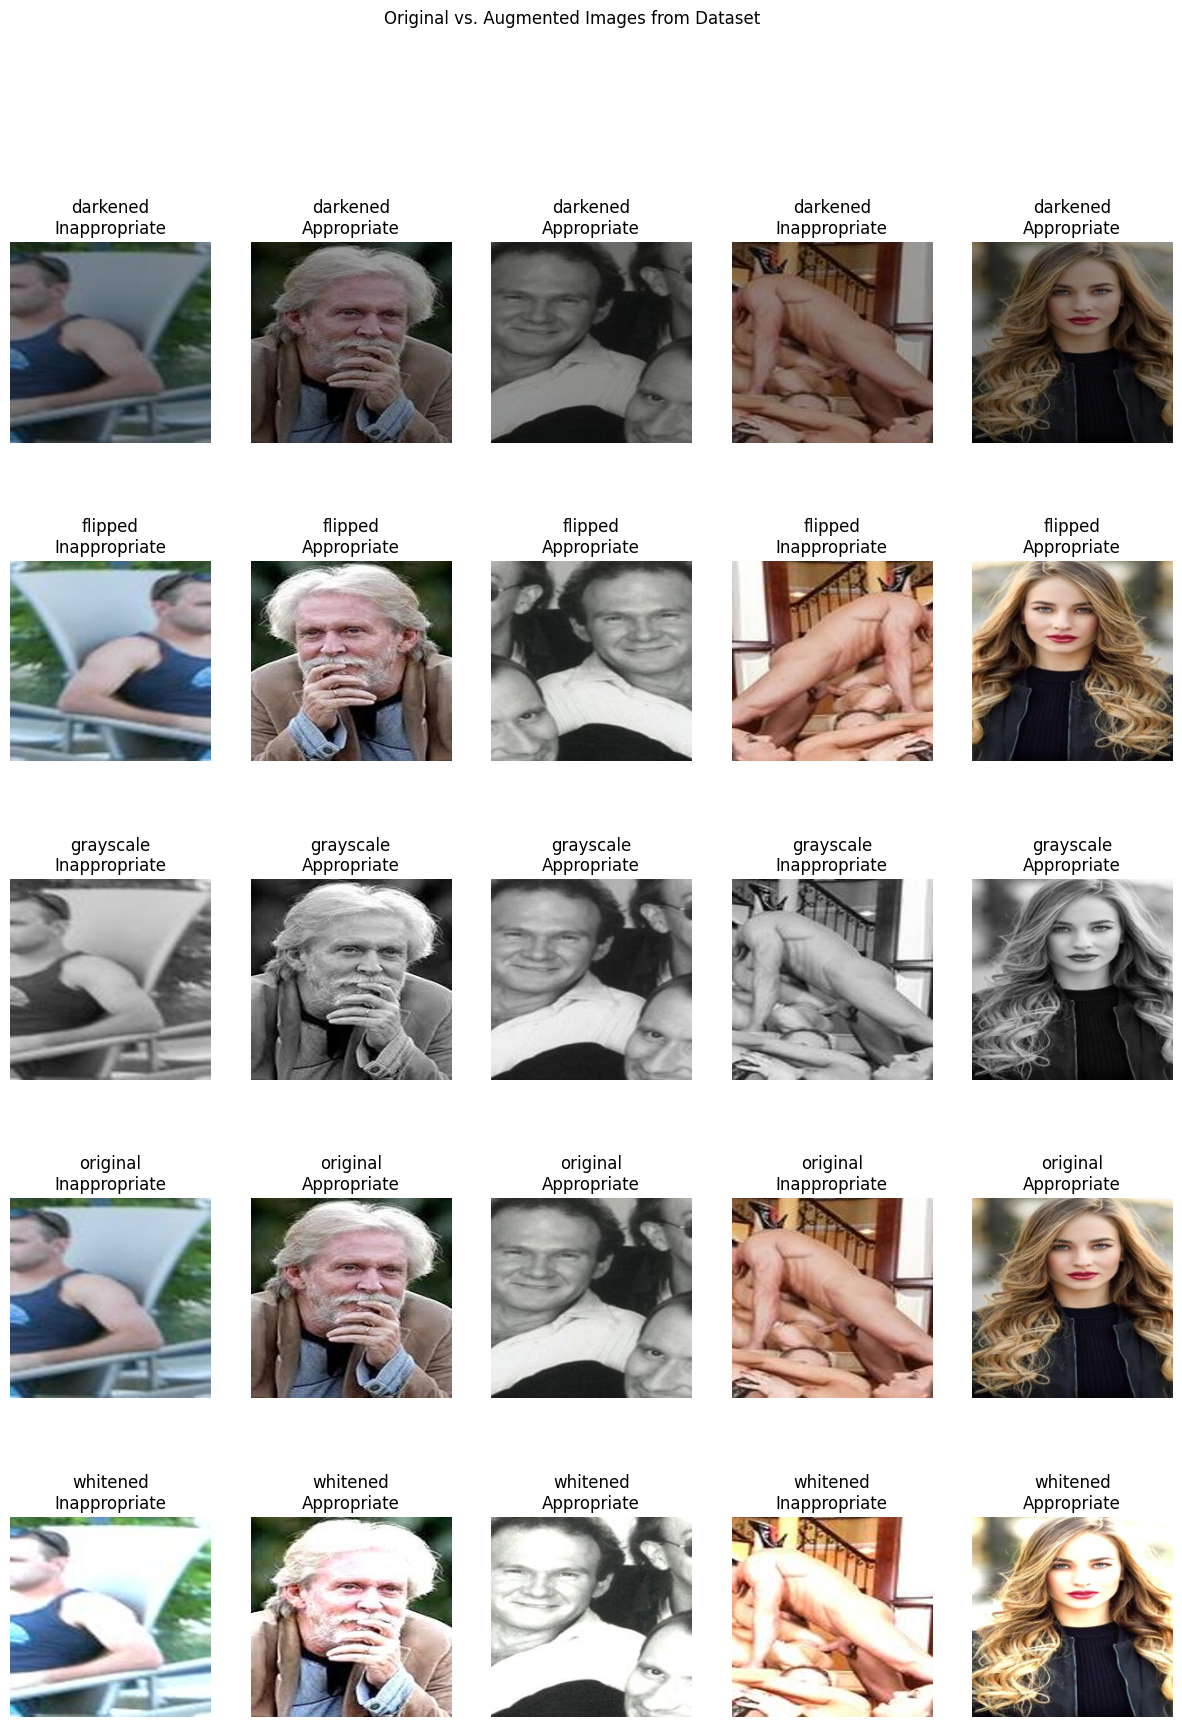

In [4]:
def denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 1, 3)
    std = torch.tensor(std).view(1, 1, 3)
    img = img * std + mean  # Undo normalization
    return img.clamp(0, 1)  # Keep values in range [0,1] for proper visualization

def show_all_augmentations(train_dataset, raw_dataset, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 20))  # 5 augmentations per image

    aug_names = ["darkened", "flipped", "grayscale", "original", "whitened"]

    for i in range(num_images):
        index = random.randint(0, len(train_dataset) // 5 - 1)  # Select a random original image
        base_idx = index * 5  # Starting index of the 5 augmentations

        # Get original file path (before transformation)
        img_path, label_original = raw_dataset.samples[index]

        # Open original image with PIL
        img_pil = Image.open(img_path)

        # # Ensure image is in RGB mode
        if img_pil.mode != "RGB":
            img_pil = img_pil.convert("RGB")

        # Load images from the transformed dataset
        for j in range(5):  # Display all 5 augmentations
            img_aug, label_aug = train_dataset[base_idx + j]

            # Move tensor to CPU before converting to NumPy
          # With this:
            img_aug = denormalize(img_aug.permute(1, 2, 0))  # Undo normalization
            img_aug_np = img_aug.cpu().numpy()
                        # Apply grayscale colormap if displaying grayscale
            cmap = "gray" if aug_names[j] == "Grayscale" else None

            # Display the image
            axes[j, i].imshow(img_aug_np, cmap=cmap)
            axes[j, i].set_title(f"{aug_names[j]}\n{raw_dataset.classes[label_aug]}")
            axes[j, i].axis("off")

    plt.suptitle("Original vs. Augmented Images from Dataset")
    plt.show()

# Call function using the correct dataset
show_all_augmentations(dataset_train, dataset_raw)


## Model Initialization

In [326]:

# class ResNet50Model(nn.Module):
#     def __init__(self):
#         super(ResNet50Model, self).__init__()
        
#         # Load pre-trained ResNet50 model
#         self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
#         # Freeze all layers initially
#         for param in self.resnet.parameters():
#             param.requires_grad = False
        
#         # Replace the fully connected layer
#         self.resnet.fc = nn.Identity()
        
#         # New classification layer
#         self.batch_norm = nn.BatchNorm1d(2048)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.fc = nn.Linear(2048, 1)
        
#     def forward(self, x):
#         features = self.resnet(x)
#         features = self.batch_norm(features)
#         features = self.relu(features)
#         features = self.dropout(features)
#         output = torch.sigmoid(self.fc(features))
#         return output
    

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.inception import Inception_V3_Weights

class InceptionV3Model(nn.Module):
    def __init__(self):
        super(InceptionV3Model, self).__init__()

        # Load pre-trained InceptionV3 model
        pretrained_model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        self.inception = models.inception_v3(aux_logits=False)
        state_dict = pretrained_model.state_dict()
        self.inception.load_state_dict(state_dict, strict=False)
        
        # Freeze all layers initially
        for param in self.inception.parameters():
            param.requires_grad = False

        # Remove the fully connected layer
        self.inception.fc = nn.Identity()

        # Replace it with a new classification layer
        self.inception.fc = nn.Linear(2048, 1)

    def forward(self, x):
        # Handle both training and evaluation modes properly
        x = self.inception(x)
        if isinstance(x, tuple):
            x = x[0]  # Get the main output, ignore auxiliary outputs
        output = torch.sigmoid(x)
        return output
    
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        
        # Load pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
   

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        self.resnet.fc = nn.Identity()
        # Replace the fully connected layer with a new classification layer
        self.resnet.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        output = torch.sigmoid(self.resnet(x))
        return output


model= InceptionV3Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



e:\THESIS PROJECT FOLDER\.venv\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:

# for param in base_model_resnet.resnet.layer4.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# for param in base_model_resnet.resnet.layer3.parameters():  # Unfreezing layer4 (last block)
#     param.requires_grad = True
# for param in base_model_resnet.resnet.layer4[2].parameters():  # Unfreeze last block in layer3
#     param.requires_grad = True
        
# # for param in base_model_resnet.resnet.layer3[4].parameters():  # Unfreeze last block in layer3
# #     param.requires_grad = True

# for param in base_model_resnet.resnet.layer3[5].parameters():  # Unfreeze second last block in layer3
#     param.requires_grad = True

    
# for param in base_model_resnet.inception.Mixed_7c.parameters():
#     param.requires_grad = True

# for param in base_model_resnet.inception.Mixed_7b.parameters():
#     param.requires_grad = True

# for param in base_model_resnet.inception.Mixed_7a.parameters():
#     param.requires_grad = True

# for param in base_model_resnet.inception.Mixed_6e.parameters():
#     param.requires_grad = True

# for param in base_model_resnet.inception.Mixed_6d.parameters():
#     param.requires_grad = True


### model summary

In [40]:
torch.set_printoptions(threshold=10_000)  # Adjust threshold if needed
print(model)
# summary(base_model_resnet, input_size=(1, 3, 224, 224))

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

ResNet50Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

## Plots

In [37]:
def plot_from_history(history):
    # Extract data from history
    epochs = history["epoch"]
    train_losses = history["train_loss"]
    val_losses = history["val_loss"]
    train_accuracies = history["train_accuracy"]
    val_accuracies = history["val_accuracy"]

    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker='o')
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="red", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # plt.savefig('training_history.png')  # PNG image
    plt.show()
  
def plot_roc_curve(metrics):
    auc_score = metrics['auc_roc'][0]
  
    roc_fpr = list(map(float, metrics['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics['roc_curve_tpr'][0].split(', ')))
    # Plot ROC Curve
    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()
def plot_metrics(metrics_df):
    # Extract individual metrics
    auc_score = metrics_df['auc_roc'][0]
    fpr = metrics_df['fpr'][0]
    fnr = metrics_df['fnr'][0]

    # Extract confusion matrix (flattened form)
    conf_matrix = list(map(int, metrics_df['confusion_matrix'][0].split(', ')))  # Convert string to list of integers
    tn, fp, fn, tp = conf_matrix

    # Extract ROC curve data (flattened form)
    roc_fpr = list(map(float, metrics_df['roc_curve_fpr'][0].split(', ')))
    roc_tpr = list(map(float, metrics_df['roc_curve_tpr'][0].split(', ')))
    # Confusion Matrix heatmap
    conf_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Actual: 0', 'Actual: 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot FPR and FNR
    plt.figure(figsize=(8, 6))
    plt.bar(['FPR', 'FNR'], [fpr, fnr], color=['red', 'blue'])
    plt.ylabel('Rate')
    plt.title('Final FPR and FNR')
    plt.ylim(0, 1)
    plt.show()

    plt.figure()
    plt.plot(roc_fpr, roc_tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.show()


## TRAIN LOOP

### train def

In [254]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Training loop
def train_model_baseline(model, train_loader, val_loader, criterion, optimizer, epochs=5, scheduler=None, device="cuda"):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x_resnet, y = batch
            x_resnet, y = x_resnet.to(device), y.to(device).float()

            optimizer.zero_grad()
            outputs = model(x_resnet).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y).sum().item()
            total += y.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x_resnet, y = batch
                x_resnet, y = x_resnet.to(device), y.to(device).float()

                outputs = model(x_resnet).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        model.train()  # Return model to training mode
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    return history, metrics


### finetune def

In [176]:
def finetune_model_baseline(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, 
                           device="cuda", weight_decay=0.01, lr_decay_factor=1):
    history = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    # Track which parameter groups have been added to optimizer
    optimized_param_ids = set()
    
    # Track layer unfreeze history for learning rate decay management
    layer_unfreeze_history = {
        "fc": {"epoch_unfrozen": 0, "param_group_idx": 0, "no_decay": True},  # Mark FC layer to skip decay
        "Mixed_7c": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "Mixed_7b": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
        "Mixed_7a": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
    }
    
    model.to(device)

    # Start with all backbone parameters frozen
    for param in model.inception.parameters():
        param.requires_grad = False
    
    # Only FC layer is trainable initially
    for param in model.inception.fc.parameters():
        param.requires_grad = True
    
    # Initialize optimizer with only FC params
    if optimizer is None:
        optimizer = torch.optim.Adamax(model.inception.fc.parameters(), lr=0.0001, weight_decay=weight_decay)
    
    # Track which parameters are in the optimizer
    for group in optimizer.param_groups:
        for param in group["params"]:
            optimized_param_ids.add(id(param))

    for epoch in range(epochs):
        # Apply learning rate decay to previously unfrozen layers, but skip FC layer
        for layer_name, info in layer_unfreeze_history.items():
            if (info["epoch_unfrozen"] is not None and 
                epoch > info["epoch_unfrozen"] and 
                not info["no_decay"]):
                
                # Find the next unfreezing epoch after this layer was unfrozen
                next_unfreeze_epoch = float('inf')  # Default to infinity if no more unfreezing
                for other_info in layer_unfreeze_history.values():
                    if (other_info["epoch_unfrozen"] is not None and 
                        other_info["epoch_unfrozen"] > info["epoch_unfrozen"] and 
                        other_info["epoch_unfrozen"] < next_unfreeze_epoch):
                        next_unfreeze_epoch = other_info["epoch_unfrozen"]
                
                # Only apply decay if we haven't reached the next unfreezing point
                if epoch < next_unfreeze_epoch:
                    epochs_since_unfreeze = epoch - info["epoch_unfrozen"]
                    # Apply decay based on how many epochs have passed since unfreezing
                    new_lr = optimizer.param_groups[info["param_group_idx"]]["lr"] * lr_decay_factor
                    new_lr = max(new_lr, 0.000001)  # Add minimum LR limit
                    print(f"Decaying LR for {layer_name} from {optimizer.param_groups[info['param_group_idx']]['lr']:.8f} to {new_lr:.8f}")
                    optimizer.param_groups[info["param_group_idx"]]["lr"] = new_lr
                else:
                    print(f"Stopped decay for {layer_name} as new layers were unfrozen at epoch {next_unfreeze_epoch}")
        
        # Gradually unfreeze layers based on epoch
        if epoch == 10:
            print("Unfreezing Mixed_7c")
            # Unfreeze Mixed_7c
            new_params = []
            for param in model.inception.Mixed_7c.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    new_params.append(param)
                    optimized_param_ids.add(id(param))
            
            # Add new parameter groups to optimizer if we have new params
            if new_params:
                optimizer.add_param_group({
                    "params": new_params,
                    "lr": 0.00001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["Mixed_7c"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["Mixed_7c"]["param_group_idx"] = len(optimizer.param_groups) - 1

            print("Unfreezing Mixed_7b")
            # Unfreeze Mixed_7b
            new_7b_params = []
            for param in model.inception.Mixed_7b.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    new_7b_params.append(param)
                    optimized_param_ids.add(id(param))
            
            # Add new parameter groups to optimizer if we have new params
            if new_7b_params:
                optimizer.add_param_group({
                    "params": new_7b_params,
                    "lr": 0.000005,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["Mixed_7b"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["Mixed_7b"]["param_group_idx"] = len(optimizer.param_groups) - 1

        elif epoch == 12:
            print("Unfreezing Mixed_7a")
            # Unfreeze Mixed_7a
            new_7a_params = []
            for param in model.inception.Mixed_7a.parameters():
                param.requires_grad = True
                if id(param) not in optimized_param_ids:
                    new_7a_params.append(param)
                    optimized_param_ids.add(id(param))
            
            # Add new parameter groups to optimizer if we have new params
            if new_7a_params:
                optimizer.add_param_group({
                    "params": new_7a_params,
                    "lr": 0.000001,
                    "weight_decay": weight_decay
                })
                # Record the param group index for later LR updates
                layer_unfreeze_history["Mixed_7a"]["epoch_unfrozen"] = epoch
                layer_unfreeze_history["Mixed_7a"]["param_group_idx"] = len(optimizer.param_groups) - 1
        
        # Print current learning rates for all param groups
        print("Current Learning Rates:")
        for i, param_group in enumerate(optimizer.param_groups):
            layer_name = next((name for name, info in layer_unfreeze_history.items() 
                              if info["param_group_idx"] == i), f"unknown-{i}")
            decay_status = "fixed" if any(info["no_decay"] for name, info in layer_unfreeze_history.items() 
                                         if info["param_group_idx"] == i) else "decaying"
            print(f"  Param Group {i} ({layer_name}, {decay_status}): lr = {param_group['lr']:.8f}")
            
        # Print number of trainable parameters and optimizer state
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")
        print(f"Optimizer param groups: {len(optimizer.param_groups)}")

        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        model.train()
        for batch in progress_bar:
            x, y = batch
            x, y = x.to(device), y.to(device).float()
                              
            optimizer.zero_grad()
            outputs = model(x).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
            correct += (preds == y).sum().item()
            total += y.size(0)

            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation Step
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred, y_prob = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device).float()

                outputs = model(x).squeeze()
                loss = criterion(outputs, y)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
        print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

        # Store metrics
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        # Compute Additional Metrics
        conf_matrix = confusion_matrix(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_prob)
        fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
        tn, fp, fn, tp = conf_matrix.ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("\nAdditional Metrics:") 
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Negative Rate (FNR): {fnr:.4f}")
        print(f"AUC-ROC Score: {auc_score:.4f}")
        print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        # Save Additional Metrics
        metrics["epoch"].append(epoch + 1)
        metrics["class_names"].append(["Appropriate", "Inappropriate"])
        metrics["confusion_matrix"].append(conf_matrix.ravel())
        metrics["accuracy"].append(val_acc)
        metrics["fpr"].append(fpr)
        metrics["fnr"].append(fnr)
        metrics["auc_roc"].append(auc_score)
        metrics["roc_curve_fpr"].append(fpr_vals)
        metrics["roc_curve_tpr"].append(tpr_vals)

        # Use learning rate scheduler if provided
        if scheduler:
            print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
            scheduler.step()
            print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

    print("Training complete")
    print(optimizer)
    return history, metrics
# def finetune_model_baseline(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, 
#                            device="cuda", weight_decay=0.001, lr_decay_factor=1):
#     history = {
#         "epoch": [],
#         "train_loss": [],
#         "train_accuracy": [],
#         "val_loss": [],
#         "val_accuracy": []
#     }
#     metrics = {
#         "epoch": [],
#         "class_names": [],
#         "confusion_matrix": [],
#         "accuracy": [],
#         "fpr": [],
#         "fnr": [],
#         "auc_roc": [],
#         "roc_curve_fpr": [],
#         "roc_curve_tpr": []
#     }

#     # Track which parameter groups have been added to optimizer
#     optimized_param_ids = set()
    
#     # Track layer unfreeze history for learning rate decay management
#     layer_unfreeze_history = {
#         "fc": {"epoch_unfrozen": 0, "param_group_idx": 0, "no_decay": True},  # Mark FC layer to skip decay
#         "layer4_2": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
#         "layer4_1": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
#         "layer4_0": {"epoch_unfrozen": None, "param_group_idx": None, "no_decay": False},
#     }
    
#     model.to(device)

#     # Start with all backbone parameters frozen
#     for param in model.resnet.parameters():
#         param.requires_grad = False
    
#     # Only FC layer is trainable initially
#     for param in model.resnet.fc.parameters():
#         param.requires_grad = True
    
#     # Initialize optimizer with only FC params
#     if optimizer is None:
#         optimizer = torch.optim.Adamax(model.resnet.fc.parameters(), lr=0.001, weight_decay=weight_decay)
    
#     # Track which parameters are in the optimizer
#     for group in optimizer.param_groups:
#         for param in group["params"]:
#             optimized_param_ids.add(id(param))
    
#     # Get a list of all model parameters for slicing
#     all_params = list(model.resnet.parameters())

#     for epoch in range(epochs):
#         # Apply learning rate decay to previously unfrozen layers, but skip FC layer
#         for layer_name, info in layer_unfreeze_history.items():
#             if (info["epoch_unfrozen"] is not None and 
#                 epoch > info["epoch_unfrozen"] and 
#                 not info["no_decay"]):
                
#                 # Find the next unfreezing epoch after this layer was unfrozen
#                 next_unfreeze_epoch = float('inf')  # Default to infinity if no more unfreezing
#                 for other_info in layer_unfreeze_history.values():
#                     if (other_info["epoch_unfrozen"] is not None and 
#                         other_info["epoch_unfrozen"] > info["epoch_unfrozen"] and 
#                         other_info["epoch_unfrozen"] < next_unfreeze_epoch):
#                         next_unfreeze_epoch = other_info["epoch_unfrozen"]
                
#                 # Only apply decay if we haven't reached the next unfreezing point
#                 if epoch < next_unfreeze_epoch:
#                     epochs_since_unfreeze = epoch - info["epoch_unfrozen"]
#                     # Apply decay based on how many epochs have passed since unfreezing
#                     new_lr = optimizer.param_groups[info["param_group_idx"]]["lr"] * lr_decay_factor
#                     new_lr = max(new_lr, 0.000001)  # Add minimum LR limit
#                     print(f"Decaying LR for {layer_name} from {optimizer.param_groups[info['param_group_idx']]['lr']:.8f} to {new_lr:.8f}")
#                     optimizer.param_groups[info["param_group_idx"]]["lr"] = new_lr
#                 else:
#                     print(f"Stopped decay for {layer_name} as new layers were unfrozen at epoch {next_unfreeze_epoch}")
        
#         # Gradually unfreeze layers based on epoch
#         if epoch == 10:
#             print("Unfreezing layer4[2] (last 3 params)")
#             # Get the last 3 parameters (corresponding to layer4[2])
#             last_three_params = all_params[-3:]
#             new_params = []
            
#             for param in last_three_params:
#                 param.requires_grad = True
#                 # Add to new_params list only if not already in optimizer
#                 if id(param) not in optimized_param_ids:
#                     new_params.append(param)
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer if we have new params
#             if new_params:
#                 optimizer.add_param_group({
#                     "params": new_params,
#                     "lr": 0.0001,
#                     "weight_decay": weight_decay
#                 })
#                 # Record the param group index for later LR updates
#                 layer_unfreeze_history["layer4_2"]["epoch_unfrozen"] = epoch
#                 layer_unfreeze_history["layer4_2"]["param_group_idx"] = len(optimizer.param_groups) - 1

#             print("Unfreezing layer4[1] (params -6:-3)")
#             # Get parameters -6:-3 (corresponding to layer4[1])
#             middle_three_params = all_params[-6:-3]
#             new_mid_params = []
            
#             for param in middle_three_params:
#                 param.requires_grad = True
#                 if id(param) not in optimized_param_ids:
#                     new_mid_params.append(param)
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer if we have new params
#             if new_mid_params:
#                 optimizer.add_param_group({
#                     "params": new_mid_params,
#                     "lr": 0.00005,
#                     "weight_decay": weight_decay
#                 })
#                 # Record the param group index for later LR updates
#                 layer_unfreeze_history["layer4_1"]["epoch_unfrozen"] = epoch
#                 layer_unfreeze_history["layer4_1"]["param_group_idx"] = len(optimizer.param_groups) - 1

#         elif epoch == 12:
#             print("Unfreezing layer4[0] (params -9:-6)")
#             # Get parameters -9:-6 (corresponding to layer4[0])
#             first_three_params = all_params[-9:-6]
#             new_first_params = []
            
#             for param in first_three_params:
#                 param.requires_grad = True
#                 if id(param) not in optimized_param_ids:
#                     new_first_params.append(param)
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer if we have new params
#             if new_first_params:
#                 optimizer.add_param_group({
#                     "params": new_first_params,
#                     "lr": 0.000005,
#                     "weight_decay": weight_decay
#                 })
#                 # Record the param group index for later LR updates
#                 layer_unfreeze_history["layer4_0"]["epoch_unfrozen"] = epoch
#                 layer_unfreeze_history["layer4_0"]["param_group_idx"] = len(optimizer.param_groups) - 1
        
#         # Print current learning rates for all param groups
#         print("Current Learning Rates:")
#         for i, param_group in enumerate(optimizer.param_groups):
#             layer_name = next((name for name, info in layer_unfreeze_history.items() 
#                               if info["param_group_idx"] == i), f"unknown-{i}")
#             decay_status = "fixed" if any(info["no_decay"] for name, info in layer_unfreeze_history.items() 
#                                          if info["param_group_idx"] == i) else "decaying"
#             print(f"  Param Group {i} ({layer_name}, {decay_status}): lr = {param_group['lr']:.8f}")
            
#         # Print number of trainable parameters and optimizer state
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")
#         print(f"Optimizer param groups: {len(optimizer.param_groups)}")

#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # Progress bar for training
#         progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

#         model.train()
#         for batch in progress_bar:
#             x, y = batch
#             x, y = x.to(device), y.to(device).float()
                              
#             optimizer.zero_grad()
#             outputs = model(x).squeeze()
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
#             correct += (preds == y).sum().item()
#             total += y.size(0)

#             progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

#         epoch_loss = running_loss / len(train_loader)
#         epoch_acc = 100 * correct / total

#         # Validation Step
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         y_true, y_pred, y_prob = [], [], []

#         with torch.no_grad():
#             for batch in val_loader:
#                 x, y = batch
#                 x, y = x.to(device), y.to(device).float()

#                 outputs = model(x).squeeze()
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item()

#                 preds = (outputs > 0.5).float()
#                 val_correct += (preds == y).sum().item()
#                 val_total += y.size(0)

#                 y_true.extend(y.cpu().numpy())
#                 y_pred.extend(preds.cpu().numpy())
#                 y_prob.extend(outputs.cpu().numpy())

#         val_loss /= len(val_loader)
#         val_acc = 100 * val_correct / val_total if val_total > 0 else 0

#         print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
#         print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

#         # Store metrics
#         history["epoch"].append(epoch + 1)
#         history["train_loss"].append(epoch_loss)
#         history["train_accuracy"].append(epoch_acc)
#         history["val_loss"].append(val_loss)
#         history["val_accuracy"].append(val_acc)

#         # Compute Additional Metrics
#         conf_matrix = confusion_matrix(y_true, y_pred)
#         auc_score = roc_auc_score(y_true, y_prob)
#         fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
#         tn, fp, fn, tp = conf_matrix.ravel()
#         fpr = fp / (fp + tn)
#         fnr = fn / (fn + tp)

#         print("\nAdditional Metrics:") 
#         print(f"False Positive Rate (FPR): {fpr:.4f}")
#         print(f"False Negative Rate (FNR): {fnr:.4f}")
#         print(f"AUC-ROC Score: {auc_score:.4f}")
#         print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

#         # Save Additional Metrics
#         metrics["epoch"].append(epoch + 1)
#         metrics["class_names"].append(["Appropriate", "Inappropriate"])
#         metrics["confusion_matrix"].append(conf_matrix.ravel())
#         metrics["accuracy"].append(val_acc)
#         metrics["fpr"].append(fpr)
#         metrics["fnr"].append(fnr)
#         metrics["auc_roc"].append(auc_score)
#         metrics["roc_curve_fpr"].append(fpr_vals)
#         metrics["roc_curve_tpr"].append(tpr_vals)

#         # Use learning rate scheduler if provided
#         if scheduler:
#             print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
#             scheduler.step()
#             print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

#     print("Training complete")
#     print(optimizer)
#     return history, metrics

# def finetune_model_baseline(model, train_loader, val_loader, criterion, optimizer=None, epochs=5, scheduler=None, device="cuda", weight_decay=0.001):
#     history = {
#         "epoch": [],
#         "train_loss": [],
#         "train_accuracy": [],
#         "val_loss": [],
#         "val_accuracy": []
#     }
#     metrics = {
#         "epoch": [],
#         "class_names": [],
#         "confusion_matrix": [],
#         "accuracy": [],
#         "fpr": [],
#         "fnr": [],
#         "auc_roc": [],
#         "roc_curve_fpr": [],
#         "roc_curve_tpr": []
#     }

#     # Track which parameter groups have been added to optimizer
#     optimized_param_ids = set()
    
#     model.to(device)

#     # Start with all backbone parameters frozen
#     for param in model.resnet.parameters():
#         param.requires_grad = False
    
#     # Only FC layer is trainable initially
#     for param in model.resnet.fc.parameters():
#         param.requires_grad = True
    
#     # Initialize optimizer with only FC params
#     if optimizer is None:
#         optimizer = torch.optim.Adamax(model.resnet.fc.parameters(), lr=0.001, weight_decay=weight_decay)
    
#     # Track which parameters are in the optimizer
#     for group in optimizer.param_groups:
#         for param in group["params"]:
#             optimized_param_ids.add(id(param))

#     for epoch in range(epochs):
#         # Gradually unfreeze layers based on epoch
#         if epoch == 1:
#             print("Unfreezing layer4[2]")
#             # Unfreeze specific layers
#             for param in model.resnet.layer4[2].parameters():
#                 param.requires_grad = True
#                 # Add to optimizer if not already added
#                 if id(param) not in optimized_param_ids:
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer
#             if any(p.requires_grad for p in model.resnet.layer4[2].parameters()):
#                 optimizer.add_param_group({
#                     "params": [p for p in model.resnet.layer4[2].parameters() if p.requires_grad],
#                     "lr": 0.0001,
#                     "weight_decay": weight_decay
#                 })

#         elif epoch == 2:
#             print("Unfreezing layer4[1]")
#             # Unfreeze more layers
#             for param in model.resnet.layer4[1].parameters():
#                 param.requires_grad = True
#                 if id(param) not in optimized_param_ids:
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer
#             if any(p.requires_grad for p in model.resnet.layer4[1].parameters()):
#                 optimizer.add_param_group({
#                     "params": [p for p in model.resnet.layer4[1].parameters() if p.requires_grad],
#                     "lr": 0.00005,
#                     "weight_decay": weight_decay
#                 })

#         elif epoch == 3:
#             print("Unfreezing layer4[0]")
#             # Unfreeze final set of layers
#             for param in model.resnet.layer4[0].parameters():
#                 param.requires_grad = True
#                 if id(param) not in optimized_param_ids:
#                     optimized_param_ids.add(id(param))
            
#             # Add new parameter groups to optimizer
#             if any(p.requires_grad for p in model.resnet.layer4[0].parameters()):
#                 optimizer.add_param_group({
#                     "params": [p for p in model.resnet.layer4[0].parameters() if p.requires_grad],
#                     "lr": 0.00001,
#                     "weight_decay": weight_decay
#                 })
            
#         # Print number of trainable parameters and optimizer state
#         trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"Epoch {epoch+1}: Number of trainable parameters: {trainable_params}")
#         print(f"Optimizer param groups: {len(optimizer.param_groups)}")

#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # Progress bar for training
#         progress_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

#         model.train()
#         for batch in progress_bar:
#             x, y = batch
#             x, y = x.to(device), y.to(device).float()
                              
#             optimizer.zero_grad()
#             outputs = model(x).squeeze()
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             preds = (outputs > 0.5).float()  # Convert probabilities to binary predictions
#             correct += (preds == y).sum().item()
#             total += y.size(0)

#             progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

#         epoch_loss = running_loss / len(train_loader)
#         epoch_acc = 100 * correct / total

#         # Validation Step
#         model.eval()
#         val_loss, val_correct, val_total = 0.0, 0, 0
#         y_true, y_pred, y_prob = [], [], []

#         with torch.no_grad():
#             for batch in val_loader:
#                 x, y = batch
#                 x, y = x.to(device), y.to(device).float()

#                 outputs = model(x).squeeze()
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item()

#                 preds = (outputs > 0.5).float()
#                 val_correct += (preds == y).sum().item()
#                 val_total += y.size(0)

#                 y_true.extend(y.cpu().numpy())
#                 y_pred.extend(preds.cpu().numpy())
#                 y_prob.extend(outputs.cpu().numpy())

#         val_loss /= len(val_loader)
#         val_acc = 100 * val_correct / val_total if val_total > 0 else 0

#         print(f"\nEpoch {epoch+1}/{epochs}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc:.2f}%")
#         print(f"Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_acc:.2f}%\n")

#         # Store metrics
#         history["epoch"].append(epoch + 1)
#         history["train_loss"].append(epoch_loss)
#         history["train_accuracy"].append(epoch_acc)
#         history["val_loss"].append(val_loss)
#         history["val_accuracy"].append(val_acc)

#         # Compute Additional Metrics
#         conf_matrix = confusion_matrix(y_true, y_pred)
#         auc_score = roc_auc_score(y_true, y_prob)
#         fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
#         tn, fp, fn, tp = conf_matrix.ravel()
#         fpr = fp / (fp + tn)
#         fnr = fn / (fn + tp)

#         print("\nAdditional Metrics:") 
#         print(f"False Positive Rate (FPR): {fpr:.4f}")
#         print(f"False Negative Rate (FNR): {fnr:.4f}")
#         print(f"AUC-ROC Score: {auc_score:.4f}")
#         print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

#         # Save Additional Metrics
#         metrics["epoch"].append(epoch + 1)
#         metrics["class_names"].append(["Appropriate", "Inappropriate"])
#         metrics["confusion_matrix"].append(conf_matrix.ravel())
#         metrics["fpr"].append(fpr)
#         metrics["fnr"].append(fnr)
#         metrics["auc_roc"].append(auc_score)
#         metrics["roc_curve_fpr"].append(fpr_vals)
#         metrics["roc_curve_tpr"].append(tpr_vals)

#         # Use learning rate scheduler if provided
#         if scheduler:
#             print(f"Before Step Learning Rate: {scheduler.get_last_lr()[0]}")
#             scheduler.step()
#             print(f"Current Learning Rate: {scheduler.get_last_lr()[0]}")

#     print("Training complete")
#     return history, metrics

### Train Model

In [327]:

# "STEADY LEARNING RATE"
import torch.optim.adamax


# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)
# Fsecondhistory, Fsecondmetrics = finetune_model_baseline(model, train_loader, val_loader,criterion, epochs=15, device=device )
Fsecondhistory, Fsecondmetrics = train_model_baseline(model, train_loader, val_loader,criterion, optimizer,epochs=15, device=device )


Epoch 1/15: 100%|██████████| 17/17 [00:16<00:00,  1.02it/s, accuracy=53.3, loss=0.722]



Epoch 1/15: Train Loss = 0.7014, Train Accuracy = 53.30%
Validation Loss = 0.7010, Validation Accuracy = 53.48%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.9528
AUC-ROC Score: 0.5406
TN: 118, FP: 6, FN: 101, TP: 5


Epoch 2/15: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s, accuracy=55.4, loss=0.72] 



Epoch 2/15: Train Loss = 0.6913, Train Accuracy = 55.44%
Validation Loss = 0.7004, Validation Accuracy = 54.78%


Additional Metrics:
False Positive Rate (FPR): 0.0161
False Negative Rate (FNR): 0.9623
AUC-ROC Score: 0.5283
TN: 122, FP: 2, FN: 102, TP: 4


Epoch 3/15: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s, accuracy=55.2, loss=0.703]



Epoch 3/15: Train Loss = 0.6806, Train Accuracy = 55.16%
Validation Loss = 0.6939, Validation Accuracy = 55.22%


Additional Metrics:
False Positive Rate (FPR): 0.0403
False Negative Rate (FNR): 0.9245
AUC-ROC Score: 0.5637
TN: 119, FP: 5, FN: 98, TP: 8


Epoch 4/15: 100%|██████████| 17/17 [00:17<00:00,  1.03s/it, accuracy=60.1, loss=0.667]



Epoch 4/15: Train Loss = 0.6724, Train Accuracy = 60.09%
Validation Loss = 0.6902, Validation Accuracy = 55.65%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.9057
AUC-ROC Score: 0.5889
TN: 118, FP: 6, FN: 96, TP: 10


Epoch 5/15: 100%|██████████| 17/17 [00:15<00:00,  1.08it/s, accuracy=58.8, loss=0.675]



Epoch 5/15: Train Loss = 0.6737, Train Accuracy = 58.79%
Validation Loss = 0.6849, Validation Accuracy = 56.52%


Additional Metrics:
False Positive Rate (FPR): 0.0403
False Negative Rate (FNR): 0.8962
AUC-ROC Score: 0.6272
TN: 119, FP: 5, FN: 95, TP: 11


Epoch 6/15: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s, accuracy=60.7, loss=0.681]



Epoch 6/15: Train Loss = 0.6689, Train Accuracy = 60.74%
Validation Loss = 0.6822, Validation Accuracy = 56.52%


Additional Metrics:
False Positive Rate (FPR): 0.0323
False Negative Rate (FNR): 0.9057
AUC-ROC Score: 0.6545
TN: 120, FP: 4, FN: 96, TP: 10


Epoch 7/15: 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, accuracy=61.3, loss=0.675]



Epoch 7/15: Train Loss = 0.6596, Train Accuracy = 61.30%
Validation Loss = 0.6757, Validation Accuracy = 57.83%


Additional Metrics:
False Positive Rate (FPR): 0.0403
False Negative Rate (FNR): 0.8679
AUC-ROC Score: 0.6788
TN: 119, FP: 5, FN: 92, TP: 14


Epoch 8/15: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s, accuracy=60.3, loss=0.64] 



Epoch 8/15: Train Loss = 0.6574, Train Accuracy = 60.28%
Validation Loss = 0.6702, Validation Accuracy = 60.43%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.8019
AUC-ROC Score: 0.6987
TN: 118, FP: 6, FN: 85, TP: 21


Epoch 9/15: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s, accuracy=62, loss=0.689]  



Epoch 9/15: Train Loss = 0.6573, Train Accuracy = 62.05%
Validation Loss = 0.6643, Validation Accuracy = 61.30%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.7830
AUC-ROC Score: 0.7222
TN: 118, FP: 6, FN: 83, TP: 23


Epoch 10/15: 100%|██████████| 17/17 [00:15<00:00,  1.10it/s, accuracy=63.3, loss=0.645]



Epoch 10/15: Train Loss = 0.6507, Train Accuracy = 63.35%
Validation Loss = 0.6597, Validation Accuracy = 61.74%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.7736
AUC-ROC Score: 0.7405
TN: 118, FP: 6, FN: 82, TP: 24


Epoch 11/15: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it, accuracy=63.2, loss=0.631]



Epoch 11/15: Train Loss = 0.6441, Train Accuracy = 63.16%
Validation Loss = 0.6551, Validation Accuracy = 63.48%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.7358
AUC-ROC Score: 0.7520
TN: 118, FP: 6, FN: 78, TP: 28


Epoch 12/15: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s, accuracy=64.4, loss=0.648]



Epoch 12/15: Train Loss = 0.6396, Train Accuracy = 64.37%
Validation Loss = 0.6508, Validation Accuracy = 63.91%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.7264
AUC-ROC Score: 0.7617
TN: 118, FP: 6, FN: 77, TP: 29


Epoch 13/15: 100%|██████████| 17/17 [00:15<00:00,  1.07it/s, accuracy=63.4, loss=0.65] 



Epoch 13/15: Train Loss = 0.6383, Train Accuracy = 63.44%
Validation Loss = 0.6467, Validation Accuracy = 63.48%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.7358
AUC-ROC Score: 0.7807
TN: 118, FP: 6, FN: 78, TP: 28


Epoch 14/15: 100%|██████████| 17/17 [00:16<00:00,  1.05it/s, accuracy=64.3, loss=0.617]



Epoch 14/15: Train Loss = 0.6348, Train Accuracy = 64.28%
Validation Loss = 0.6433, Validation Accuracy = 65.65%


Additional Metrics:
False Positive Rate (FPR): 0.0484
False Negative Rate (FNR): 0.6887
AUC-ROC Score: 0.7845
TN: 118, FP: 6, FN: 73, TP: 33


Epoch 15/15: 100%|██████████| 17/17 [00:16<00:00,  1.06it/s, accuracy=67.7, loss=0.629]



Epoch 15/15: Train Loss = 0.6236, Train Accuracy = 67.72%
Validation Loss = 0.6384, Validation Accuracy = 66.09%


Additional Metrics:
False Positive Rate (FPR): 0.0806
False Negative Rate (FNR): 0.6415
AUC-ROC Score: 0.7896
TN: 114, FP: 10, FN: 68, TP: 38
Training complete


In [ ]:

# "STEADY LEARNING RATE"
import torch.optim.adamax


# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)
Fsecondhistory, Fsecondmetrics = train_model_baseline(model, train_loader, val_loader,criterion, optimizer, epochs=5, device=device )


Epoch 1/5: 100%|██████████| 82/82 [00:25<00:00,  3.25it/s, accuracy=59.9, loss=0.672]



Epoch 1/5: Train Loss = 0.6715, Train Accuracy = 59.90%
Validation Loss = 0.6321, Validation Accuracy = 73.55%


Additional Metrics:
False Positive Rate (FPR): 0.1879
False Negative Rate (FNR): 0.3423
AUC-ROC Score: 0.8054
TN: 458, FP: 106, FN: 190, TP: 365


Epoch 2/5: 100%|██████████| 82/82 [00:24<00:00,  3.35it/s, accuracy=79.4, loss=0.587]



Epoch 2/5: Train Loss = 0.6002, Train Accuracy = 79.41%
Validation Loss = 0.5716, Validation Accuracy = 81.41%


Additional Metrics:
False Positive Rate (FPR): 0.2216
False Negative Rate (FNR): 0.1495
AUC-ROC Score: 0.8999
TN: 439, FP: 125, FN: 83, TP: 472


Epoch 3/5: 100%|██████████| 82/82 [00:24<00:00,  3.30it/s, accuracy=83.8, loss=0.564]



Epoch 3/5: Train Loss = 0.5448, Train Accuracy = 83.84%
Validation Loss = 0.5203, Validation Accuracy = 85.17%


Additional Metrics:
False Positive Rate (FPR): 0.1188
False Negative Rate (FNR): 0.1784
AUC-ROC Score: 0.9286
TN: 497, FP: 67, FN: 99, TP: 456


Epoch 4/5: 100%|██████████| 82/82 [00:24<00:00,  3.29it/s, accuracy=86, loss=0.474]  



Epoch 4/5: Train Loss = 0.4993, Train Accuracy = 85.98%
Validation Loss = 0.4832, Validation Accuracy = 86.15%


Additional Metrics:
False Positive Rate (FPR): 0.0993
False Negative Rate (FNR): 0.1784
AUC-ROC Score: 0.9377
TN: 508, FP: 56, FN: 99, TP: 456


Epoch 5/5: 100%|██████████| 82/82 [00:24<00:00,  3.29it/s, accuracy=87.3, loss=0.398]



Epoch 5/5: Train Loss = 0.4635, Train Accuracy = 87.30%
Validation Loss = 0.4500, Validation Accuracy = 87.67%


Additional Metrics:
False Positive Rate (FPR): 0.1418
False Negative Rate (FNR): 0.1045
AUC-ROC Score: 0.9429
TN: 484, FP: 80, FN: 58, TP: 497
Training complete


In [ ]:
# "DECAYING LEARNING RATE"
import torch.optim.adamax
criterion = nn.BCELoss()
optimizer = optim.Adamax(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=0.001)

            # Set DataLoaders
train_loader_resnet = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False,  num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False,  num_workers=4, pin_memory=True)
            # Use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.00001)
            # Train the model
Fsecondhistory, Fsecondmetrics = train_model_baseline(model, train_loader_resnet, val_loader, 
                                                       criterion, optimizer, epochs=5, scheduler=scheduler)

Epoch 1/5: 100%|██████████| 245/245 [01:11<00:00,  3.43it/s, accuracy=75.9, loss=0.556]



Epoch 1/5: Train Loss = 0.6026, Train Accuracy = 75.86%
Validation Loss = 0.5106, Validation Accuracy = 86.60%


Additional Metrics:
False Positive Rate (FPR): 0.1724
False Negative Rate (FNR): 0.0961
AUC-ROC Score: 0.9453
TN: 461, FP: 96, FN: 54, TP: 508
Before Step Learning Rate: 0.0001
Current Learning Rate: 9.140576474687264e-05


Epoch 2/5: 100%|██████████| 245/245 [01:09<00:00,  3.55it/s, accuracy=85.5, loss=0.404]



Epoch 2/5: Train Loss = 0.4835, Train Accuracy = 85.50%
Validation Loss = 0.4228, Validation Accuracy = 88.65%


Additional Metrics:
False Positive Rate (FPR): 0.1598
False Negative Rate (FNR): 0.0676
AUC-ROC Score: 0.9569
TN: 468, FP: 89, FN: 38, TP: 524
Before Step Learning Rate: 9.140576474687264e-05
Current Learning Rate: 6.890576474687263e-05


Epoch 3/5: 100%|██████████| 245/245 [01:58<00:00,  2.06it/s, accuracy=86.8, loss=0.403]



Epoch 3/5: Train Loss = 0.4260, Train Accuracy = 86.75%
Validation Loss = 0.3845, Validation Accuracy = 88.11%


Additional Metrics:
False Positive Rate (FPR): 0.1688
False Negative Rate (FNR): 0.0694
AUC-ROC Score: 0.9584
TN: 463, FP: 94, FN: 39, TP: 523
Before Step Learning Rate: 6.890576474687263e-05
Current Learning Rate: 4.1094235253127366e-05


Epoch 4/5: 100%|██████████| 245/245 [02:52<00:00,  1.42it/s, accuracy=87.3, loss=0.427]



Epoch 4/5: Train Loss = 0.3997, Train Accuracy = 87.27%
Validation Loss = 0.3651, Validation Accuracy = 89.01%


Additional Metrics:
False Positive Rate (FPR): 0.1418
False Negative Rate (FNR): 0.0783
AUC-ROC Score: 0.9599
TN: 478, FP: 79, FN: 44, TP: 518
Before Step Learning Rate: 4.1094235253127366e-05
Current Learning Rate: 1.8594235253127368e-05


Epoch 5/5: 100%|██████████| 245/245 [01:52<00:00,  2.17it/s, accuracy=87.3, loss=0.421]



Epoch 5/5: Train Loss = 0.3894, Train Accuracy = 87.28%
Validation Loss = 0.3575, Validation Accuracy = 88.38%


Additional Metrics:
False Positive Rate (FPR): 0.1598
False Negative Rate (FNR): 0.0730
AUC-ROC Score: 0.9601
TN: 468, FP: 89, FN: 41, TP: 521
Before Step Learning Rate: 1.8594235253127368e-05
Current Learning Rate: 1e-05
Training complete


### Model Eval Using Test Set

In [336]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load("FINETUNING/Prosed/Model/fixedresnet_inception_fullmodel_cropped5epochs_finetune2.pt")
model.to(device)
model.eval()
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4,pin_memory=True)

def evaluate_resnet_model():
    test_metrics = {
        "epoch": [],
        "class_names": [],
        "confusion_matrix": [],
        "accuracy": [],
        "fpr": [],
        "fnr": [],
        "auc_roc": [],
        "roc_curve_fpr": [],
        "roc_curve_tpr": []
    }

    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device).float()
            outputs = model(x).squeeze()
            preds = (outputs > 0.5).cpu().int().numpy()

            # Store ground-truth labels and predictions
            y_true.extend(y.cpu().int().numpy())
            y_pred.extend(preds)
            y_prob.extend(outputs.cpu().numpy())  # Probabilities for AUC

    # Compute Additional Metrics for Test Set
    conf_matrix = confusion_matrix(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_prob)
    fpr_vals, tpr_vals, _ = roc_curve(y_true, y_prob)
    tn, fp, fn, tp = conf_matrix.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)

    # Print Test Metrics
    print("\nTest Set Metrics:")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("**Fine-Tuned Model Evaluation**")

    # Store metrics in dictionary
    test_metrics["class_names"].append(["Appropriate", "Inappropriate"]) 
    test_metrics["confusion_matrix"].append(conf_matrix.ravel())  # Flatten confusion matrix to a list
    test_metrics["fpr"].append(fpr)
    test_metrics["fnr"].append(fnr)
    test_metrics["auc_roc"].append(auc_score)
    test_metrics["roc_curve_fpr"].append(fpr_vals)
    test_metrics["roc_curve_tpr"].append(tpr_vals)

    # Classification Report & Accuracy
    report = classification_report(y_true, y_pred, digits=5)
    accuracy = accuracy_score(y_true, y_pred)
    print(report)
    print(f"Accuracy Score: {accuracy}")

    return test_metrics, report, accuracy


test_metrics, report, accuracy = evaluate_resnet_model()

ValueError: The provided filename FINETUNING/Prosed/Model/fixedresnet_inception_fullmodel_cropped5epochs_finetune2.pt does not exist

### Training results


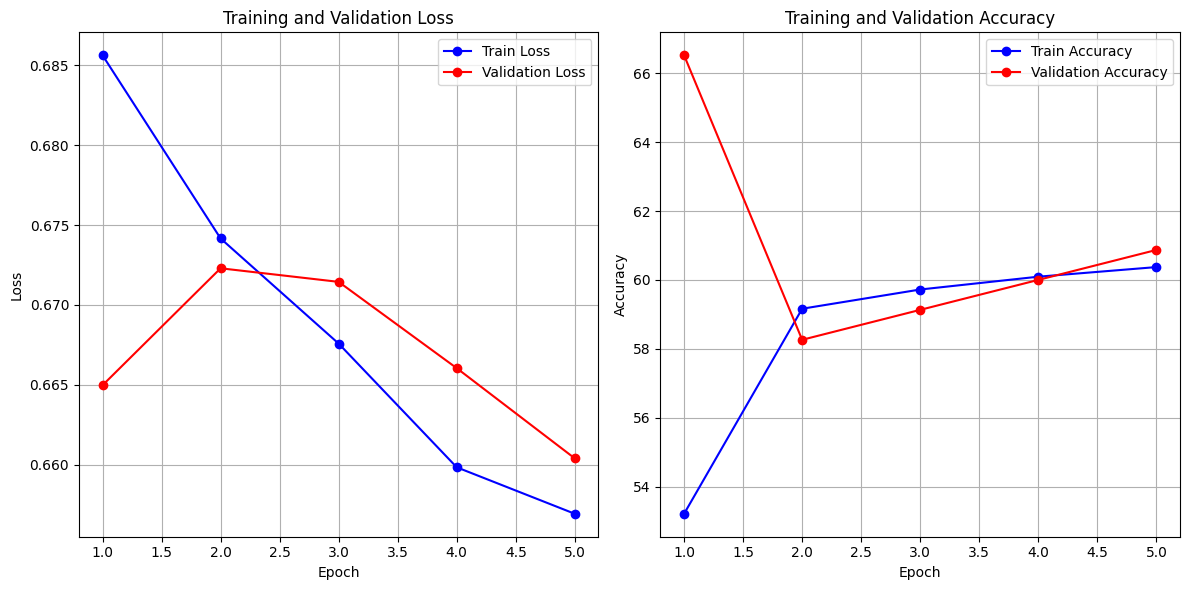

In [317]:
plot_from_history(Fsecondhistory)

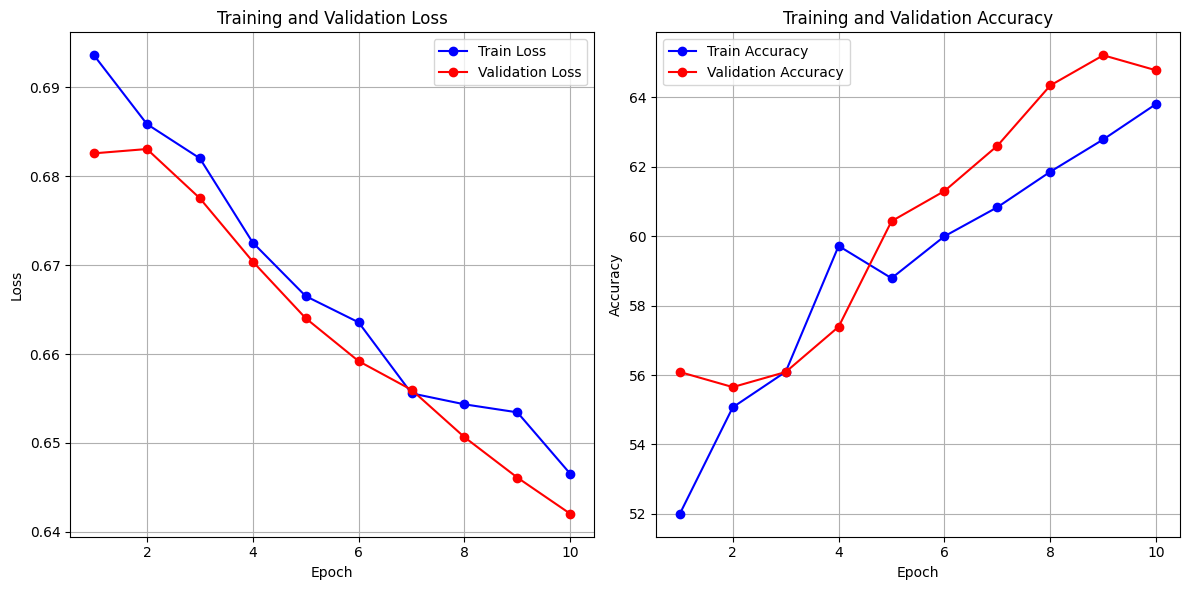

In [323]:
plot_from_history(Fsecondhistory)

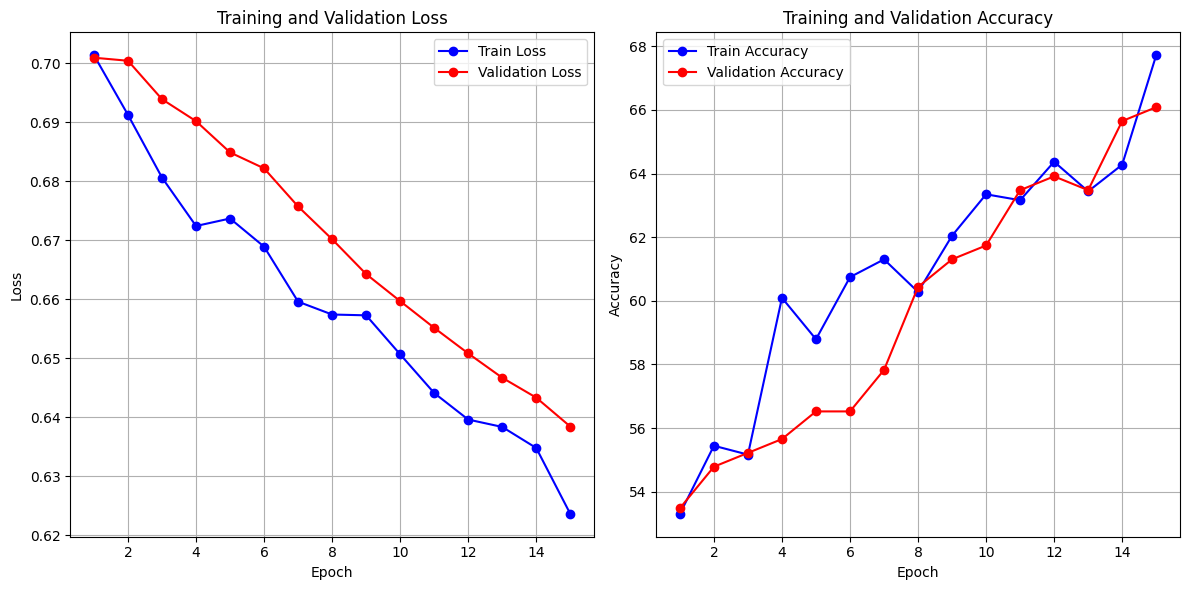

In [329]:
plot_from_history(Fsecondhistory)

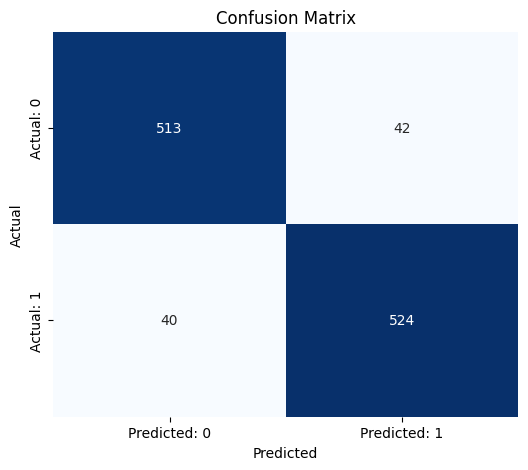

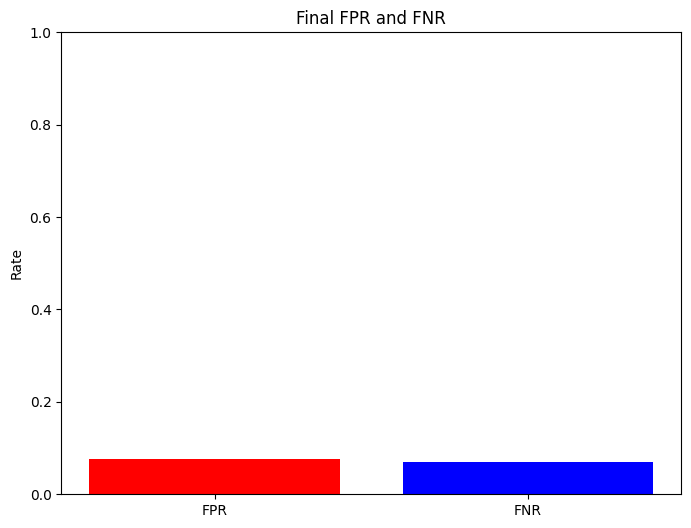

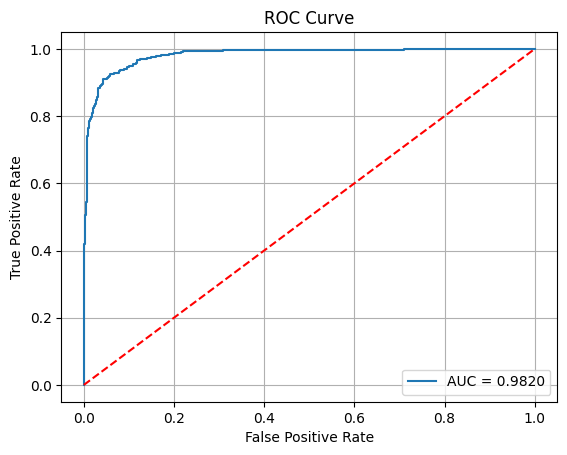

In [27]:
metrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}

# plot_roc_curve(metrics_flat)
plot_metrics(metrics_flat)

### Save training results

In [330]:
metrics_flat = {
    "class_names": test_metrics["class_names"],
    "fpr": test_metrics["fpr"],
    "fnr": test_metrics["fnr"],
    "auc_roc": test_metrics["auc_roc"],
    "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
    "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
    "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
}
with open("Inception/INCEPTION_classification_report15epochsMMU_noaug.txt", "w") as file:
    file.write(report + "\n")
    file.write(f"Accuracy Score: {accuracy}\n") 

df = pd.DataFrame(Fsecondhistory)
df.to_csv('Inception/INCEPTION_training_history15epochsMMU_noaug.csv', index=False)
metrics_df = pd.DataFrame(metrics_flat)
metrics_df.to_csv('Inception/INCEPTION_training_metrics15epochsMMU_noaug.csv', index=False)



In [ ]:
# metrics_flat = {
#     "class_names": test_metrics["class_names"],
#     "fpr": test_metrics["fpr"],
#     "fnr": test_metrics["fnr"],
#     "auc_roc": test_metrics["auc_roc"],
#     "roc_curve_fpr": [', '.join(map(str, fpr_vals)) for fpr_vals in test_metrics["roc_curve_fpr"]],
#     "roc_curve_tpr": [', '.join(map(str, tpr_vals)) for tpr_vals in test_metrics["roc_curve_tpr"]],
#     "confusion_matrix": [', '.join(map(str, cm)) for cm in test_metrics["confusion_matrix"]]
# }
# with open("FINETUNING/Baseline/fixedBaseline_classification_report15epochs_finetuneF.txt", "w") as file:
#     file.write(report + "\n")  # Write the classification report
#     file.write(f"Accuracy Score: {accuracy}\n") 

# df = pd.DataFrame(Fsecondhistory)
# df.to_csv('FINETUNING/Baseline/fixedBaseline_training_history15epochs_finetuneF.csv', index=False)
# metrics_df = pd.DataFrame(metrics_flat)
# metrics_df.to_csv('FINETUNING/Baseline/fixedBaseline_training_metrics15epochs_finetuneF.csv', index=False)



#### Read Train Results

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       555
           1       0.84      0.88      0.86       564

    accuracy                           0.85      1119
   macro avg       0.85      0.85      0.85      1119
weighted avg       0.85      0.85      0.85      1119

Accuracy Score: 0.8525469168900804



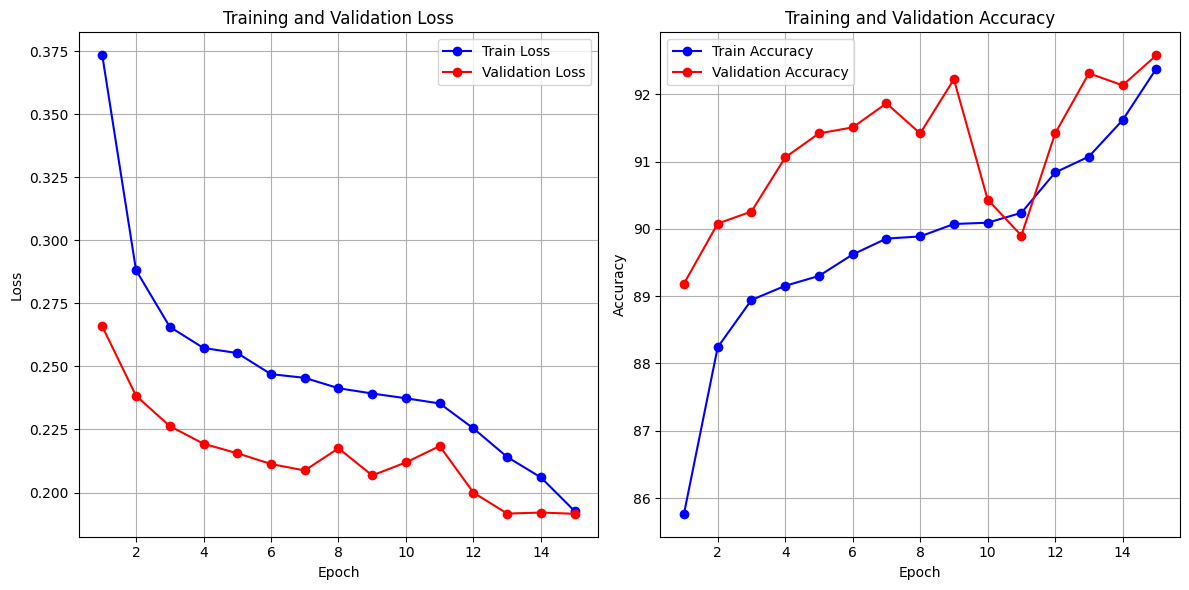

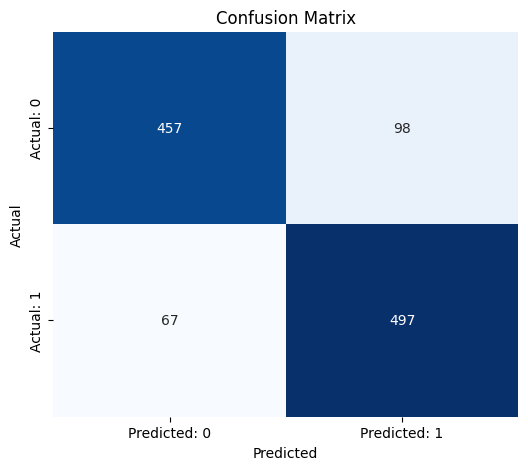

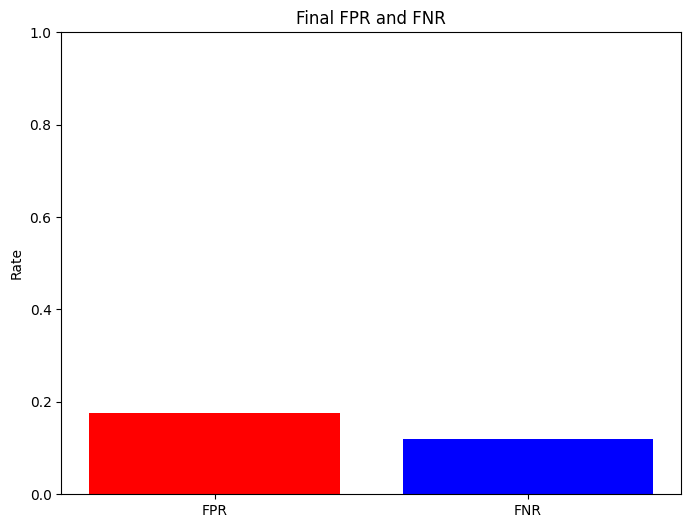

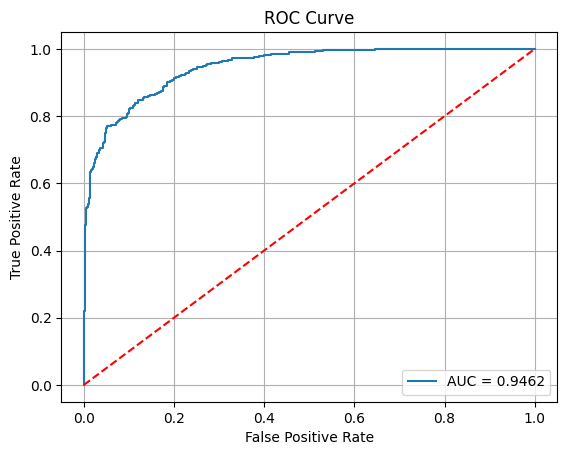

In [ ]:
with open("training_history/fixedBaseline_classification_report5epochs_non-aug.txt", "r") as file:
    report = file.read()

print(report)

history_df = pd.read_csv('FINETUNING/Baseline/fixedBaseline_training_history10epochs_finetuneF.csv')
history = {
    'epoch': history_df['epoch'].tolist(),
    'train_loss': history_df['train_loss'].tolist(),
    'val_loss': history_df['val_loss'].tolist(),
    'train_accuracy': history_df['train_accuracy'].tolist(),
    'val_accuracy': history_df['val_accuracy'].tolist(),
}
plot_from_history(history)
metrics_df = pd.read_csv('training_history/fixedBaseline_training_metrics10epochs_non-aug.csv')

plot_metrics(metrics_df)

##  Save Models


In [331]:
# torch.save(model, "../Saved models/fixedBaseline_resnet_fullmodel_cropped5epochs_finetune.pth")
scripted_model = torch.jit.script(model)  # Convert model to TorchScript
scripted_model.save("Inception/Model/INCEPTION_resnet_fullmodel_cropped15epochsMMU_noaug.pt")

### Use saved Model

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

import warnings
class_names = ['Appropriate', 'Inappropriate']

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


base_model = torch.jit.load("../Saved models/Baseline_resnet_fullmodel_croppedv7.pt")
base_model.to(device)
base_model.eval()

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])


def preprocess_image(img_path):
    img_resnet = Image.open(img_path).convert('RGB')
    # Apply transformations for ResNet and Inception
    img_tensor_resnet = resnet_transform(img_resnet).unsqueeze(0)  # Add batch dimension
    
    return img_tensor_resnet

def predict_image(img_path):
    img_tensor_resnet = preprocess_image(img_path)
    img_tensor_resnet = img_tensor_resnet.to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        outputs = base_model(img_tensor_resnet)
        predicted_value = outputs.item()  # Extract scalar prediction

    # Return class name based on threshold
    predicted_class = class_names[int(predicted_value > 0.5)]
    return predicted_class

print(class_names)
# Test prediction
new_img_path = './DARKNET/test.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test1.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test2.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test3.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test4.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test5.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test6.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/test7.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")
new_img_path = './DARKNET/zeb.jpg'
predicted_class = predict_image(new_img_path)
print(f"Predicted Class for {new_img_path}: {predicted_class}")